This notebook shows how to design a transmon pocket (single pad design) in qiskit metal. The notebook only need **TransmonPocket_Single** function from a relative path '../../resources'.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
#This imports the necessary path to draw the single pad transmon design. 
import sys
sys.path.append('Customized_Components')
from single_pad_transmon_pocket import TransmonPocket_Single
import Transmon_property as trans_p

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [48]:
import os
import shutil

In [3]:
import numpy as np
import astropy.units as u
import astropy.constants as c

import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline

In [4]:
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond

from qiskit_metal.qlibrary.tlines.mixed_path import RouteMixed
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

from qiskit_metal.analyses.quantization import LOManalysis
from qiskit_metal.analyses.quantization import EPRanalysis

from qiskit_metal.toolbox_metal.parsing import *

In [5]:
# from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
# from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround


In [6]:
pd.read_csv("Frequencies from metal pad size.csv",).plot(x= 'Pad_len (mm)', y = 'EPR Frequency (GHz)')
plt.ylabel('Frequency (GHz)')
plt.show()

In [7]:
phi0 = c.h/2/c.e.si
T = 30*u.mK
epsilon_r = 11.45

The target frequency is around 4.2GHz. To get this frequency, we need the pad size to be around 0.275mm.

## Global variables

In [8]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '20 mm'
design.chips.main.size['size_y'] = '10 mm'

design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

design.variables['trace_width'] = '10 um'
design.variables['trace_gap'] = '7 um'

# design.chips['main']['material'] = 'Silicon'

gui = MetalGUI(design)

Component-specific variables

In [9]:


qb_options = dict(
pad_pocket_distance_top = '40um',
connection_pads = dict(
    a = dict(loc_W  = 1, 
            loc_H =  1, 
            pad_gap = '10um',
            pad_height = '20um',
            pad_width = '80um',
            pad_cpw_extent =  '10um',
            pocket_rise = '0um',
            cpw_extend = '5um')))

TQ_options = dict(prime_width = design.variables['cpw_width'],
               prime_gap = design.variables['cpw_gap'],
               second_width = design.variables['trace_width'],
               second_gap = design.variables['trace_gap'],
               down_length = '60um',
               coupling_space = '5um',
               open_termination=False,
               hfss_wire_bonds = False,
               q3d_wire_bonds = False)

CPW_options = Dict(trace_width = design.variables['trace_width'],
               trace_gap  = design.variables['trace_gap'],
        total_length='5 mm',
        hfss_wire_bonds = True,
        q3d_wire_bonds = True,
        fillet='30 um',
        lead = dict(start_straight='20um', end_straight = '50um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Q1', pin='a'),
            end_pin=Dict(component='TQ1', pin='second_end')), )

pin_inputs = Dict(
            start_pin=Dict(component='Q1', pin='a'),
            end_pin=Dict(component='TQ1', pin='second_end'))

trans_options = Dict(hfss_wire_bonds = True,
                     q3d_wirebonds = True,
               pin_inputs=Dict(
                 start_pin=Dict(
                     component='TQ1',
                     pin='prime_start'),
                 end_pin=Dict(
                     component='TQ2',
                     pin='prime_end')))


## Single Pad--Verify Design

### Draw the single pad transmon

In [10]:
design.delete_all_components()

In [11]:
design.overwrite_enabled = True

size = 0.25*u.mm
gap = 30*u.um
size = size.to(u.um)
pocket_width = size+2*gap


op = Dict(
    pos_x = '0',
    pad_height = '{}um'.format(size.value),
    pos_y = '0',
    pad_width = '{}'.format(size),
    pocket_width = '{}'.format(pocket_width), 
    **qb_options)

q1 = TransmonPocket_Single(design,'Q1',options = op)

gui.rebuild()
gui.zoom_on_components(['Q1'])


In [12]:
q1.options.hfss_inductance = '13nH'
q1.options.q3d_inductance =  '13nH'
gui.rebuild()
gui.autoscale()

### Single pad capacitance

In [15]:
#The cell below will give an error. Go to ansys, draw a cube, and go into the material selection window
#clone the property for Si and change permitivity to 11.45. Change the name to "LL_Si" 

#Rerun the following cell

In [13]:
c1 = LOManalysis(design, "q3d")
# c1.sim.setup.max_passes = 5
c1.sim.setup.min_passes  = 10
c1.sim.setup.max_passes = 20

c1.sim.run(components=['Q1'])#, open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
c1.sim.capacitance_matrix 

c1.sim._get_results_from_renderer()
c_mat = c1.sim.capacitance_matrix
    
    # print(c_mat)
    
    # return(c_mat, design, q1)

INFO 02:10PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:10PM [analyze]: Analyzing setup Setup
INFO 02:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpmbqxl6s9.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmphovlh4rg.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvr5j2w5v.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0xh2h4uh.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

In [14]:
c_mat

,a_connector_pad_Q1,pad_top_Q1
a_connector_pad_Q1,139.68538,-103.13006
pad_top_Q1,-103.13006,106.86539


### Single Pad Frequency

In [28]:
eig_qb = EPRanalysis(design, 'hfss')

eig_qb.sim.setup.max_passes = 25
eig_qb.sim.setup.max_delta_f = 0.05
eig_qb.sim.setup.n_modes = 1
eig_qb.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF')
eig_qb.sim.renderer.options['Lj'] = '13nH'
eig_qb.sim.renderer.options['x_buffer_width_mm'] = 0.5
eig_qb.sim.renderer.options['y_buffer_width_mm'] = 0.5
eig_qb.sim.run(name="Transmons_{}".format(0), components=['Q1'], open_terminations=[('Q1', 'a')])
convergence = pd.read_csv('hfss_eig_f_convergence.csv')

INFO 07:42PM [connect_project]: Connecting to Ansys Desktop API...
INFO 07:42PM [load_ansys_project]: 	Opened Ansys App
INFO 07:42PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 07:42PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/slab/Documents/Ansoft/
	Project:   Project27
INFO 07:42PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 07:42PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 07:42PM [connect]: 	Connected to project "Project27" and design "Design_q3d" 😀 

INFO 07:42PM [connect_design]: 	Opened active design
	Design:    Transmons_0_hfss [Solution type: Eigenmode]
WARNING 07:42PM [connect_setup]: 	No design setup detected.
WARNING 07:42PM [connect_setup]: 	Creating eigenmode default setup.
INFO 07:42PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 07:42PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 07:42PM 

In [29]:
del eig_qb.setup.junctions['jj']
eig_qb.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_',
                Lj_variable='Lj1', Cj_variable='Cj1')
eig_qb.setup.sweep_variable = 'Lj1'
eig_qb.run_epr()

chi = eig_qb.sim.renderer.epr_quantum_analysis.get_chis().to_numpy()[0][0]
freq_EPR= eig_qb.sim.renderer.epr_quantum_analysis.get_frequencies().to_numpy()[0][0]

Design "Transmons_0_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_0_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.99311109232643e-25
        energy_elec_substrate = 1.83133785175256e-25
        EPR of substrate = 91.9%

        energy_mag    = 1.28021980532291e-27
        energy_mag % of energy_elec_all  = 0.6%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.22 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.4%  9.966e-26 6.401e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 98.21%
	jj1             0.992539  (+)        0.0181126
		(U_tot_cap-U_tot_ind)/mean=0.95%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.918833806506469


  options=pd.Series(get_instance_vars(self.options)),

WARNING 07:44PM [__init__]: <p>Error: <class 'IndexError'></p>
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project27\Transmons_0_hfss\2023-03-02 19-44-10.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.019233
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.974881

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.99

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       174

*** Chi matrix ND (MHz) 
       191

*** Frequencies O1 PT (MHz)
0    4041.987462
dtype: float64

*** Frequencies ND (MHz)
0    4034.040416
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,4034.04


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,191.41


In [30]:
Cq = -c_mat['a_connector_pad_Q1']['pad_top_Q1']*u.fF
Lj = 13*u.nH
Ec = (c.e.si**2/2/Cq).to(u.J)
Ej = ((phi0/2/np.pi)**2/Lj).to(u.J)
wq = (np.sqrt(8*Ej*Ec)-Ec)/c.hbar
fq = wq/2/np.pi
print('the analytical value for qubit frequency is', fq.to(u.GHz))

the analytical value for qubit frequency is 4.1730386916961075 GHz


In [31]:


print('Frequency from Finite Element Analysis:', convergence.dropna()['re(Mode(1)) [g]'].values[-1], 'GHz')
print('Frequency from pyEPR analysis:', freq_EPR/1000, 'GHz')

Frequency from Finite Element Analysis: 4.21648502761548 GHz
Frequency from pyEPR analysis: 4.03404041624079 GHz


### Draw the Tee and the CPW

In [32]:
TQ1 = CoupledLineTee(design, 'TQ1', options=dict(pos_x='-0.2 mm',
                                             pos_y='0.5 mm',
                                             coupling_length='120 um', **TQ_options))

gui.rebuild()
gui.autoscale()

In [33]:
buffer = 150*u.um
anchors = trans_p.anchor_CPW(q1, buffer, 0.07, 2,r = -1)

In [34]:
design.delete_component('cpw_1')

gui.rebuild()
gui.autoscale()

07:52PM 15s INFO [delete_component]: Called delete_component cpw_1, but such a component is not in the design cache dictionary of components.


In [35]:
pin_inputs = Dict(
            start_pin=Dict(component='Q1', pin='a'),
            end_pin=Dict(component='TQ1', pin='second_end'))

CPW_options['pin_inputs'] = pin_inputs

In [36]:
qa = RouteMixed(design, 'cpw_1', options = Dict(anchors = anchors, **CPW_options))

gui.rebuild()
gui.autoscale()

## Capacitance Matrix

### Simulate capacitave coupling between CPW and qubit

In [104]:
TQ1.options['open_termination']=True

gui.rebuild()
gui.autoscale()


In [108]:
c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 30,
 'min_passes': 10,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative',
 'run': {'name': None,
  'components': ['Q1', 'cpw_1', 'TQ1'],
  'open_terminations': None,
  'box_plus_buffer': True}}

In [105]:
c1 = LOManalysis(design, "q3d")
c1.sim.setup.min_passes  = 10
c1.sim.setup.max_passes = 30
c1.sim.setup.freq_ghz = 5

c1.sim.run(components=['Q1','cpw_1','TQ1'])#, open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
c1.sim.capacitance_matrix 

c1.sim._get_results_from_renderer()
c_mat = c1.sim.capacitance_matrix

INFO 04:40PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 04:40PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:40PM [analyze]: Analyzing setup Setup
INFO 04:43PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpm8r200fb.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:43PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpa4op691h.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:43PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpbtwqn071.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 04:43PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmppifigll2.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

In [106]:
c_mat

,a_connector_pad_Q1,g_wb,pad_top_Q1
a_connector_pad_Q1,670.22403,-655.18112,-13.33405
g_wb,-655.18112,812.66663,-96.94281
pad_top_Q1,-13.33405,-96.94281,112.90425


In [109]:
c1 = LOManalysis(design, "q3d")
c1.sim.setup.min_passes  = 10
c1.sim.setup.max_passes = 30
c1.sim.setup.freq_ghz = 4

c1.sim.run(components=['Q1','cpw_1','TQ1'])#, open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
c1.sim.capacitance_matrix 

c1.sim._get_results_from_renderer()
c_mat = c1.sim.capacitance_matrix

INFO 04:46PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 04:46PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:46PM [analyze]: Analyzing setup Setup
INFO 04:49PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpji9bcr5d.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 4000000000, Maxwell, 1, False
INFO 04:49PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmphv20hgvs.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4000000000, Maxwell, 1, False
INFO 04:49PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpund2p_s8.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4000000000, Maxwell, 2, False
INFO 04:49PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpaip3nph_.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4000000000, 

In [110]:
c_mat

,a_connector_pad_Q1,g_wb,pad_top_Q1
a_connector_pad_Q1,670.22403,-655.18112,-13.33405
g_wb,-655.18112,812.66663,-96.94281
pad_top_Q1,-13.33405,-96.94281,112.90425


In [111]:
c1.sim.setup.freq_ghz = 7
c1.sim.run(components=['Q1','cpw_1','TQ1'])

INFO 04:50PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 04:50PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:50PM [analyze]: Analyzing setup Setup
INFO 04:53PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpah2uljmp.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 7000000000, Maxwell, 1, False
INFO 04:53PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2utvwvsp.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 7000000000, Maxwell, 1, False
INFO 04:53PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpp16427yj.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 7000000000, Maxwell, 2, False
INFO 04:53PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgsszjw4b.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 7000000000, 

In [112]:
c_mat = c1.sim.capacitance_matrix
c_mat

,a_connector_pad_Q1,g_wb,pad_top_Q1
a_connector_pad_Q1,670.22403,-655.18112,-13.33405
g_wb,-655.18112,812.66663,-96.94281
pad_top_Q1,-13.33405,-96.94281,112.90425


From the above three iterations, the frequency we choose for capacitance matrix simulation has no effect on the outcome. 

## CPW only

### Analytically calculate the CPW frequency

In [83]:
from Transmon_property import find_guided_wavelength, find_actual_frequency, find_total_len

In [18]:
frequency = 7*u.GHz
line_width = 15*u.um
line_gap = 9*u.um

In [19]:
find_guided_wavelength(frequency, 10*u.um, 7*u.um).to(u.mm)/4

<Quantity 4.35433845 mm>

In [20]:
l = find_total_len(qa, q1, TQ1, count_extend = True)
find_actual_frequency(l, 10*u.um, 7*u.um)

<Quantity 7.20045854 GHz>

In [21]:
x, y = trans_p.find_connector_coord(q1) #save the position of the end of the connector pad

In [22]:
design.delete_component('cpw_1')
design.delete_component('Q1')
gui.rebuild()
gui.autoscale()

### Simulate lam/4 CPW frequency 

In [23]:
otg_options = Dict(pos_x = '{}'.format(x),pos_y = '{}'.format(y), width = '10um', gap = '7um', orientation = '180')

otg = OpenToGround(design,'otg', otg_options)

In [24]:
start = Dict(component = 'otg', pin = 'open')
CPW_options['pin_inputs']['start_pin'] = start

qa = RouteMixed(design, 'cpw_1', options = Dict(anchors = anchors, **CPW_options))

gui.rebuild()
gui.autoscale()

EPR analysis

In [28]:
eig_res = EPRanalysis(design, 'hfss')

hfss = eig_res.sim.renderer

eig_res.sim.renderer.options['Lj'] = '13nH'
eig_res.sim.renderer.options['wb_threshold'] = '100um'
eig_res.sim.renderer.options['wb_size'] = 1.7

eig_res.sim.setup.max_passes = 15
eig_res.sim.setup.max_delta_f = 0.2
eig_res.sim.setup.n_modes = 1
eig_res.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF')
eig_res.sim.renderer.options['x_buffer_width_mm'] = 0.5
eig_res.sim.renderer.options['y_buffer_width_mm'] = 0.5
eig_res.sim.run(name="readout", components=['cpw_1','TQ1','otg'])#, open_terminations=[('Q1', 'a')])
convergence = pd.read_csv('hfss_eig_f_convergence.csv')

INFO 02:38PM [connect_design]: 	Opened active design
	Design:    readout_hfss [Solution type: Eigenmode]
INFO 02:38PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:38PM [analyze]: Analyzing setup Setup
02:40PM 24s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


In [29]:
freq1 = convergence.dropna()['re(Mode(1)) [g]'].values[-1]*u.GHz

INFO 02:42PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


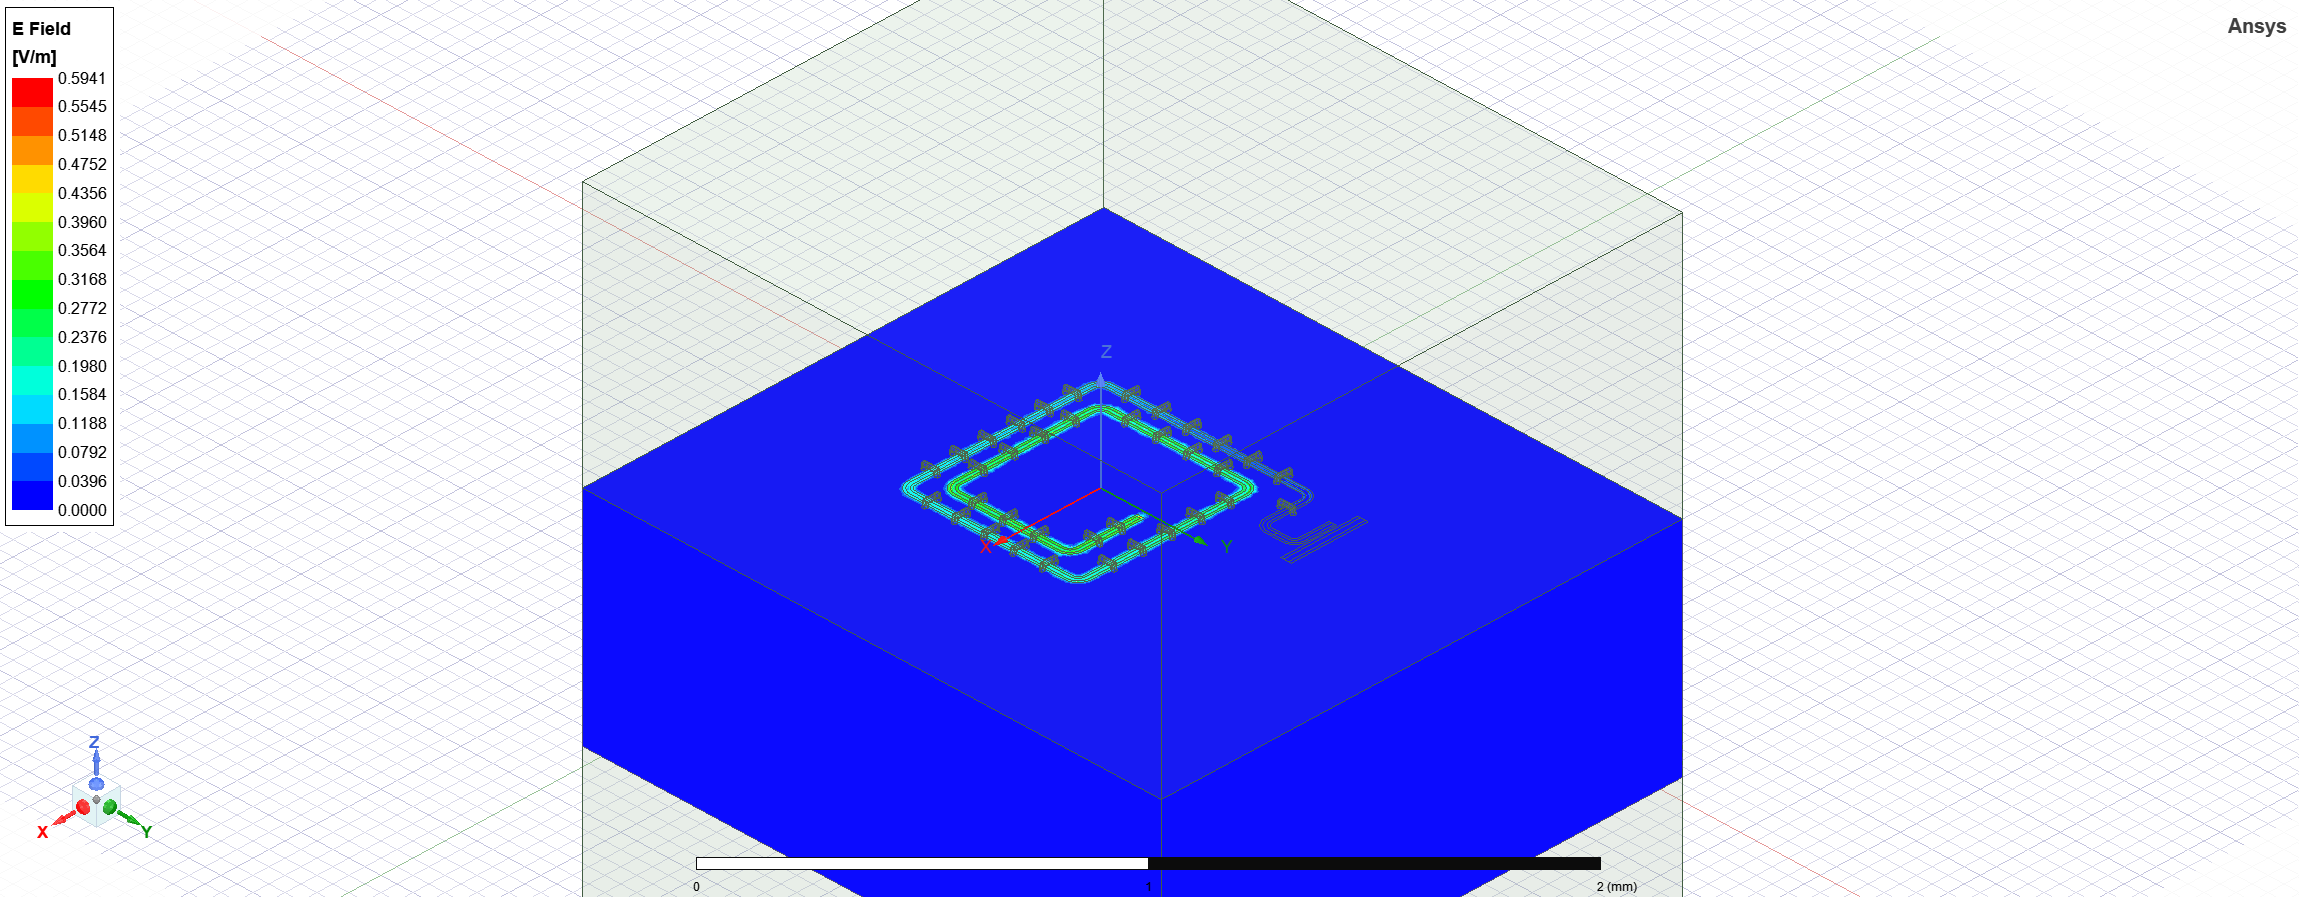

WindowsPath('c:/Users/slab/Desktop/Wendy-qiskit-code/ansys.png')

In [30]:
eig_res.sim.plot_fields('main')
eig_res.sim.save_screenshot()

In [31]:
del eig_res.setup.junctions['jj']

In [32]:
eig_res.run_epr(no_junctions = True)

Design "readout_hfss" info:
	# eigenmodes    1
	# variations    1
Design "readout_hfss" info:
	# eigenmodes    1
	# variations    1

        energy_elec_all       = 1.81746024842884e-24
        energy_elec_substrate = 1.65641877672925e-24
        EPR of substrate = 91.1%

        energy_mag    = 1.817462167495e-24
        energy_mag % of energy_elec_all  = 100.0%
        


In [33]:
eig_res.sim.renderer.options['wb_threshold'] = '70um'


eig_res.sim.run(name="readout", components=['cpw_1','TQ1','otg'])#, open_terminations=[('Q1', 'a')])
convergence = pd.read_csv('hfss_eig_f_convergence.csv')

INFO 02:42PM [connect_design]: 	Opened active design
	Design:    readout_hfss [Solution type: Eigenmode]
INFO 02:42PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:42PM [analyze]: Analyzing setup Setup
02:44PM 06s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


In [34]:
freq2 = convergence.dropna()['re(Mode(1)) [g]'].values[-1]*u.GHz

In [35]:
print('The 100um spaced wirebond gives CPW frequency', freq1)
print('The 70um spaced wirebond gives CPW frequency', freq2)

The 100um spaced wirebond gives CPW frequency 7.00989540994778 GHz
The 70um spaced wirebond gives CPW frequency 7.01339216983569 GHz


INFO 02:44PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


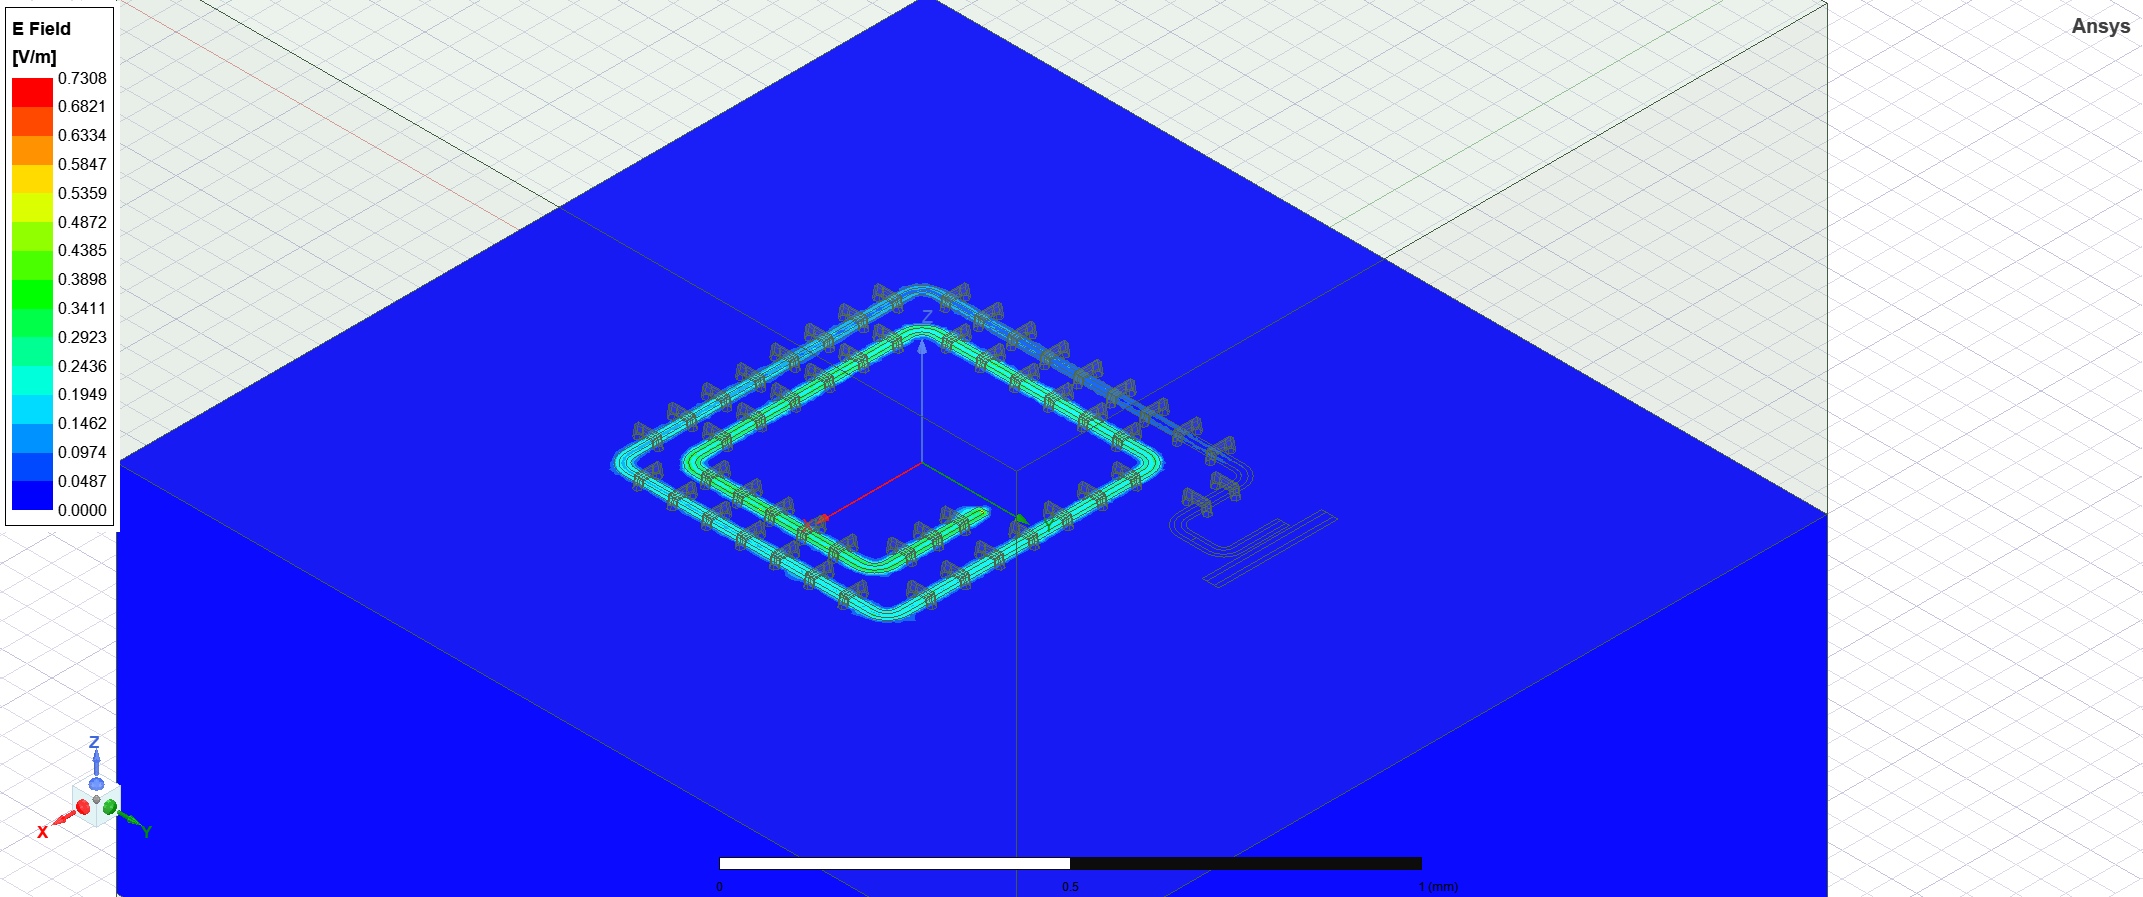

WindowsPath('c:/Users/slab/Desktop/Wendy-qiskit-code/ansys.png')

In [36]:
eig_res.sim.plot_fields('main')
eig_res.sim.save_screenshot()

In [37]:
del eig_res.setup.junctions['jj']

KeyError: 'jj'

In [38]:
eig_res.run_epr(no_junctions = True)

Design "readout_hfss" info:
	# eigenmodes    1
	# variations    1
Design "readout_hfss" info:
	# eigenmodes    1
	# variations    1

        energy_elec_all       = 1.81216712945896e-24
        energy_elec_substrate = 1.64764180012149e-24
        EPR of substrate = 90.9%

        energy_mag    = 1.81216822035635e-24
        energy_mag % of energy_elec_all  = 100.0%
        


In [81]:
# eig_res.sim.close()

In [59]:
design.delete_component('cpw_1')
design.delete_component('otg')
gui.rebuild()
gui.autoscale()

02:53PM 48s INFO [delete_component]: Called delete_component cpw_1, but such a component is not in the design cache dictionary of components.
02:53PM 48s INFO [delete_component]: Called delete_component otg, but such a component is not in the design cache dictionary of components.


In [68]:

data = pd.DataFrame()
sizes = np.linspace(0.15,0.3,10)*u.mm
freq_ls = []
len_ls = []
size_ls = []

In [69]:
for size in sizes:
    dic = {}
    design.delete_component('otg')
    design.delete_component('cpw_1')
    #draw transmon pocket design
    # size = 0.25*u.mm
    gap = 30*u.um
    size = size.to(u.um)
    pocket_width = size+2*gap

    op = Dict(
        pos_x = '0',
        pad_height = '{}um'.format(size.value),
        pos_y = '0',
        pad_width = '{}'.format(size),
        pocket_width = '{}'.format(pocket_width), 
        **qb_options)

    q1 = TransmonPocket_Single(design,'Q1',options = op)
    gui.rebuild()
    
    #calculate CPW anchors based on transmon pocket dimensions
    buffer = 150*u.um
    anchors = trans_p.anchor_CPW(q1, buffer, 0.07, 2,r = -1)

    #get coordinates
    x, y = trans_p.find_connector_coord(q1) #save the position of the end of the connector pad
    gui.rebuild()
    
    design.delete_component('Q1')
    gui.rebuild()
    gui.autoscale()

    #draw the open to ground component
    otg_options = Dict(pos_x = '{}'.format(x),pos_y = '{}'.format(y), width = 'trace_width', gap = 'trace_gap', orientation = '180')
    otg = OpenToGround(design,'otg', otg_options)

    #draw the CPW resonator
    start = Dict(component = 'otg', pin = 'open')
    CPW_options['pin_inputs']['start_pin'] = start

    qa = RouteMixed(design, 'cpw_1', options = Dict(anchors = anchors, **CPW_options))
    gui.rebuild()

    #setup simulation. Assume already ran once
    eig_res.sim.renderer.options['wb_threshold'] = '70um'

    eig_res.sim.setup.max_passes = 25
    eig_res.sim.setup.max_delta_f = 0.05
    eig_res.sim.setup.n_modes = 1

    #run the simulation
    eig_res.sim.run(name="readout", components=['cpw_1','TQ1','otg'])#, open_terminations=[('Q1', 'a')])
    convergence = (pd.read_csv('hfss_eig_f_convergence.csv')).dropna()
    ind = list(convergence.keys())[1]
    
    l = trans_p.find_total_len_nqb(qa, TQ1)
    f = convergence[ind].values[-1]
    freq_ls += [f]
    len_ls += [l.value]
    size_ls += [size.to(u.mm).value]
    
    dic['Frequency(GHz)'] = freq_ls
    dic['CPW_lengths(mm)'] = len_ls
    dic['Size(mm)'] = size_ls
    
    data = pd.DataFrame(dic)
    data.to_csv('Freq_length_CPW.csv')
    



INFO 03:00PM [connect_design]: 	Opened active design
	Design:    readout_hfss [Solution type: Eigenmode]
INFO 03:00PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 03:00PM [analyze]: Analyzing setup Setup
03:04PM 46s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv
INFO 03:04PM [connect_design]: 	Opened active design
	Design:    readout_hfss [Solution type: Eigenmode]
INFO 03:04PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 03:04PM [analyze]: Analyzing setup Setup
03:09PM 13s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv
03:09PM 14s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 03:09PM [connect_design]: 	Opened active design
	Design:    readou

In [75]:
len_ls = np.array(len_ls)*u.mm
freqs_theory = trans_p.find_actual_frequency(len_ls,10*u.um, 7*u.um)

In [81]:
plt.figure()
plt.scatter(len_ls, freqs_theory, label = 'Theory value')
plt.scatter(len_ls,freq_ls,label = 'HFSS Simulation')
plt.xlabel('CPW Length (mm)')
plt.ylabel('CPW Frequency (GHz)')
plt.legend()
plt.savefig('plots\CPW_frequencies.png')
plt.show()

In [82]:
design.delete_component('cpw_1')
design.delete_component('otg')
gui.rebuild()
gui.autoscale()

In [264]:
eig_qb_cpw = EPRanalysis(design, 'hfss')

eig_qb_cpw.sim.setup.max_passes = 25
eig_qb_cpw.sim.setup.max_delta_f = 0.05
eig_qb_cpw.sim.setup.n_modes = 3
eig_qb_cpw.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF')
eig_qb_cpw.sim.renderer.options['x_buffer_width_mm'] = 0.5
eig_qb_cpw.sim.renderer.options['y_buffer_width_mm'] = 0.5
eig_qb_cpw.sim.run(name="all_freqs", components=['Q1','cpw_1','TQ1'])#, open_terminations=[('Q1', 'a')])
convergence = pd.read_csv('hfss_eig_f_convergence.csv')

INFO 01:14PM [connect_design]: 	Opened active design
	Design:    all_freqs_hfss [Solution type: Eigenmode]
WARNING 01:14PM [connect_setup]: 	No design setup detected.
WARNING 01:14PM [connect_setup]: 	Creating eigenmode default setup.
INFO 01:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:14PM [analyze]: Analyzing setup Setup
02:59PM 52s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


In [265]:
del eig_qb_cpw.setup.junctions['jj']
eig_qb_cpw.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_',
                Lj_variable='Lj1', Cj_variable='Cj1')
eig_qb_cpw.setup.sweep_variable = 'Lj1'
eig_qb_cpw.run_epr()

chi = eig_qb_cpw.sim.renderer.epr_quantum_analysis.get_chis().to_numpy()[0][0]
freq_EPR= eig_qb_cpw.sim.renderer.epr_quantum_analysis.get_frequencies().to_numpy()[0][0]

Design "all_freqs_hfss" info:
	# eigenmodes    3
	# variations    1
Design "all_freqs_hfss" info:
	# eigenmodes    3
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.56306879484299e-26
        energy_elec_substrate = 2.36095027362388e-26
        EPR of substrate = 92.1%

        energy_mag    = 2.31839388425387e-28
        energy_mag % of energy_elec_all  = 0.9%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.03 GHz   [1/3]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%  1.282e-26 1.159e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.36%
	jj1             0.990636  (+)        0.0164836
		(U_tot_cap-U_tot_ind)/mean=0.83%
Calculating Qdielectric_main for mode 0 (0/2)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9211419835371638


  _Om = pd.Series({})




  Mode 1 at 9.46 GHz   [2/3]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.3%   1.68e-26 1.676e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 91.59%
	jj1             0.00250125  (+)        0.000229682
		(U_tot_cap-U_tot_ind)/mean=0.01%
Calculating Qdielectric_main for mode 1 (1/2)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.9205470526609205


  _Om = pd.Series({})




  Mode 2 at 28.13 GHz   [3/3]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               -0.8%  1.642e-26 1.654e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_2j   sign s_2j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 55.18%
	jj1             9.03204e-05  (+)        7.33762e-05
		(U_tot_cap-U_tot_ind)/mean=-0.39%
Calculating Qdielectric_main for mode 2 (2/2)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_2 = 0.9209669837801766


  options=pd.Series(get_instance_vars(self.options)),

WARNING 05:26PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project24\all_freqs_hfss\2023-02-23 17-24-41.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization


  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



Pm_norm=
modes
0     1.016885
1     1.046236
2    41.718963
dtype: float64

Pm_norm idx =
     jj1
0   True
1  False
2  False
*** P (participation matrix, not normlz.)
        jj1
0  0.974571
1  0.002501
2  0.000090

*** S (sign-bit matrix)
   s_jj1
0     -1
1     -1
2      1
*** P (participation matrix, normalized.)
      0.99
    0.0025
     9e-05

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       158     1.88    0.202
      1.88  0.00556  0.00119
     0.202  0.00119 6.42e-05

*** Chi matrix ND (MHz) 
       173     2.04      0.2
      2.04  0.00555  0.00111
       0.2  0.00111 6.37e-05

*** Frequencies O1 PT (MHz)
0     3866.957647
1     9457.474400
2    28133.035045
dtype: float64

*** Frequencies ND (MHz)
0     3860.023562
1     9457.425257
2    28133.035578
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1, 2]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,3860.02
1,9457.43
2,28133.04


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1         2
Lj1                              
13  0  173.16  2.04e+00  2.00e-01
    1    2.04  5.55e-03  1.11e-03
    2    0.20  1.11e-03  6.37e-05

In [315]:
chi

173.16298627369022

In [499]:
freq_EPR

3860.0235620350777

In [500]:
eig_qb_cpw.sim.renderer.epr_quantum_analysis.get_frequencies().to_numpy()

array([[ 3860.02356204],
       [ 9457.42525686],
       [28133.03557817]])

# Two Qubit design

In [17]:
design.delete_all_components()

## Draw

### Transmission Line

In [16]:

TQ_options['down_length'] = '40 um'

TQ1 = CoupledLineTee(design, 'TQ1', options=dict(pos_x='-0.23 mm',
                                             pos_y='0.5 mm', 
                                             mirror = True,
                                             coupling_length='120 um', **TQ_options))

TQ2 = CoupledLineTee(design, 'TQ2', options=dict(pos_x='0.43 mm',
                                             pos_y='0.5 mm',
                                             mirror = True,
                                             coupling_length='120 um', **TQ_options))

trans_options['pin_inputs']['start_pin']['component'] = 'TQ1'
trans_options['pin_inputs']['start_pin']['pin'] = 'prime_end'
trans_options['pin_inputs']['end_pin']['component'] = 'TQ2'
trans_options['pin_inputs']['end_pin']['pin'] = 'prime_start'
middle = RouteStraight(design, 'CPW_mid', trans_options)

wb_left = LaunchpadWirebond(design,'wb_left', options = Dict(pos_x = '-0.6mm',pos_y = '0.5mm'))
wb_left = LaunchpadWirebond(design,'wb_right', options = Dict(pos_x = '15mm',pos_y = '0.5mm',orientation = '180'))

trans_options['pin_inputs']['start_pin']['component'] = 'wb_left'
trans_options['pin_inputs']['start_pin']['pin'] = 'tie'
trans_options['pin_inputs']['end_pin']['component'] = 'TQ1'
trans_options['pin_inputs']['end_pin']['pin'] = 'prime_start'

left = RouteStraight(design,'CPW_left', trans_options)

trans_options['pin_inputs']['start_pin']['component'] = 'wb_right'
trans_options['pin_inputs']['start_pin']['pin'] = 'tie'
trans_options['pin_inputs']['end_pin']['component'] = 'TQ2'
trans_options['pin_inputs']['end_pin']['pin'] = 'prime_end'

right = RouteStraight(design,'CPW_right', trans_options)


gui.rebuild()
gui.zoom_on_components(['TQ1','TQ2'])

### Qubit 1

In [17]:
size1 = 250*u.um
size2 = 230*u.um
gap = 30*u.um
size1 = size1.to(u.um)
pocket_width1 = size1+2*gap
pocket_width2 = size2+2*gap


q1 = TransmonPocket_Single(design,'Q1', 
                           options = Dict(pocket_width = '{}'.format(pocket_width1),
                                          pad_width = '{}'.format(size1), 
                           pad_height = '{}'.format(size1),
                           pos_x = '0', pox_y = '0', **qb_options))

anchor = trans_p.anchor_CPW(q1, 150*u.um,0.05,2,last_offset = 0.4)
# last = anchor[len(anchor)-1]
# first = anchor[0]
# anchor[len(anchor)-1] = np.array([first[0]-0.05,last[1]])

design.delete_component('cpw1')
pin_inputs['start_pin']['component'] = 'Q1'
pin_inputs['start_pin']['pin'] = 'a'
pin_inputs['end_pin']['component'] = 'TQ1'
pin_inputs['end_pin']['pin'] = 'second_end'
CPW_options['pin_inputs'] = pin_inputs
op = Dict(anchors = anchor, **CPW_options)


cpw1 = RouteMixed(design, 'cpw_1', op)

gui.rebuild()
gui.autoscale()

gui.zoom_on_components(['Q1', 'cpw_1','TQ1'])

02:12PM 58s INFO [delete_component]: Called delete_component cpw1, but such a component is not in the design cache dictionary of components.


Calculate CPW1 length and analytical frequency

In [18]:
len1 = trans_p.find_total_len(cpw1, q1,TQ1,count_extend=True)
print(len1)
trans_p.find_actual_frequency(len1, 10*u.um, 7*u.um)

4.377362787842316 mm


<Quantity 6.96318094 GHz>

### Qubit 2

In [19]:
q2 = TransmonPocket_Single(design,'Q2',
                           options = Dict(pocket_width = '{}'.format(pocket_width2),
                                          pad_width = '{}'.format(size2), 
                           pad_height = '{}'.format(size2),
                           pos_x = '0.65', pox_y = '0', **qb_options))


anchor = trans_p.anchor_CPW(q2, 150*u.um,0.05,2,last_offset = 0.4)
# last = anchor[len(anchor)-1]
# first = anchor[0]
# anchor[len(anchor)-1] = np.array([first[0]-0.05,last[1]])

design.delete_component('cpw2')
pin_inputs['start_pin']['component'] = 'Q2'
pin_inputs['end_pin']['component'] = 'TQ2'
CPW_options['pin_inputs'] = pin_inputs
op = Dict(anchors = anchor, **CPW_options)


cpw2 = RouteMixed(design, 'cpw_2', op)

gui.rebuild()
gui.zoom_on_components(['Q2', 'cpw_2','TQ2'])

02:13PM 03s INFO [delete_component]: Called delete_component cpw2, but such a component is not in the design cache dictionary of components.


Calculate CPW1 length and analytical frequency

In [20]:
len2 = trans_p.find_total_len(cpw2, q2,TQ1,count_extend=True)
print(len2)
trans_p.find_actual_frequency(len2, 10*u.um, 7*u.um)

4.207362787842316 mm


<Quantity 7.24453076 GHz>

## Simulate

In [21]:
qcomps = design.components  # short handle (alias)
qcomps['Q1'].options['hfss_inductance'] = 'Lj1'
qcomps['Q1'].options['hfss_capacitance'] = 'Cj1'
qcomps['Q2'].options['hfss_inductance'] = 'Lj2'
qcomps['Q2'].options['hfss_capacitance'] = 'Cj2'



q1.options.hfss_inductance = '13 nH'
q2.options.hfss_inductance = '13 nH'
gui.rebuild()  # line needed to propagate the updates from the qubit instance into the junction design table
gui.autoscale()

In [22]:
cs = LOManalysis(design, "q3d")
cs.sim.setup.min_passes  = 10
cs.sim.setup.max_passes = 30
cs.sim.setup.freq_ghz = 4

In [23]:
eig_qb = EPRanalysis(design, 'hfss')
    
eig_qb.sim.setup.max_passes = 15
eig_qb.sim.setup.max_delta_f = 0.2
eig_qb.sim.setup.n_modes = 2
# eig_qb.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF')
# eig_qb.sim.setup.vars = Dict(Lj2= '13 nH', Cj2= '0 fF')

eig_qb.sim.renderer.options['x_buffer_width_mm'] = 0.5
eig_qb.sim.renderer.options['y_buffer_width_mm'] = 0.5

### Q1 CPW1

In [64]:
TQ1.options['open_termination'] = True
gui.rebuild()

cs.sim.run(components=['Q1','cpw_1','TQ1'])

INFO 09:31PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:31PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:31PM [analyze]: Analyzing setup Setup
INFO 09:34PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfa4c939q.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 4000000000, Maxwell, 1, False
INFO 09:34PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvsnyot1t.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4000000000, Maxwell, 1, False
INFO 09:34PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpz30s0k91.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4000000000, Maxwell, 2, False
INFO 09:34PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpok7nfc6a.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4000000000, 

In [65]:
cs.sim.capacitance_matrix

,a_connector_pad_Q1,g_wb,pad_top_Q1
a_connector_pad_Q1,665.27129,-650.02031,-13.49760
g_wb,-650.02031,796.97349,-93.27465
pad_top_Q1,-13.49760,-93.27465,108.72911


In [66]:
TQ1.options['open_termination'] = False
gui.rebuild()

In [67]:
eig_qb.sim.run(name="Transmons_CPW", components=['Q1', 'cpw_1','TQ1'])

INFO 09:34PM [connect_design]: 	Opened active design
	Design:    Transmons_CPW_hfss [Solution type: Eigenmode]
INFO 09:35PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 09:35PM [analyze]: Analyzing setup Setup
09:40PM 39s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


In [68]:
fs = eig_qb.get_frequencies()

Design "Transmons_CPW_hfss" info:
	# eigenmodes    2
	# variations    1
Design "Transmons_CPW_hfss" info:
	# eigenmodes    2
	# variations    1


In [70]:
fs

Freq. (GHz)  Quality Factor
variation mode                             
0         0        4.161082             inf
          1        6.956481             inf

In [74]:
eig_qb.sim.renderer.options['Lj1'] = '13nH'
eig_qb.sim.renderer.options['Cj1'] = '0'

In [76]:
del eig_qb.setup.junctions['jj']

KeyError: 'jj'

In [77]:
qcomps = design.components  # short handle (alias)
qcomps['Q1'].options['hfss_inductance'] = 'Lj1'
qcomps['Q1'].options['hfss_capacitance'] = 'Cj1'
gui.rebuild()  # line needed to propagate the updates from the qubit instance into the junction design table
gui.autoscale()

In [78]:
eig_qb.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF')

eig_qb.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_',
                Lj_variable='Lj1', Cj_variable='Cj1')
eig_qb.setup.sweep_variable = 'Lj1'
eig_qb.run_epr()

Design "Transmons_CPW_hfss" info:
	# eigenmodes    2
	# variations    1
Design "Transmons_CPW_hfss" info:
	# eigenmodes    2
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.35473482138455e-24
        energy_elec_substrate = 1.23156659202961e-24
        EPR of substrate = 90.9%

        energy_mag    = 1.35031174925656e-24
        energy_mag % of energy_elec_all  = 99.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.16 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  1.991e-25 1.895e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.25%
	jj1             0.990164  (+)        0.0175976
		(U_tot_cap-U_tot_ind)/mean=0.89%
Calculating Qdielectric_main for mode 0 (0/1)


  sol = sol.append(self.get_Qdielectric(

  _Om = pd.Series({})



p_dielectric_main_0 = 0.9165344172436739

  Mode 1 at 6.96 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.3%  6.774e-25 6.752e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.27%
	jj1             0.00326511  (+)        0.000162185
		(U_tot_cap-U_tot_ind)/mean=0.01%
Calculating Qdielectric_main for mode 1 (1/1)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.9090831449736702


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:11PM [__init__]: <p>Error: <class 'IndexError'></p>
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project29\Transmons_CPW_hfss\2023-03-02 22-11-34.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.018009
1    1.024887
dtype: float64

Pm_norm idx =
     jj1
0   True
1  False
*** P (participation matrix, not normlz.)
        jj1
0  0.973041
1  0.003265

*** S (sign-bit matrix)
   s_jj1
0      1
1     -1
*** P (participation matrix, normalized.)
      0.99
    0.0033

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       169     1.86
      1.86  0.00513

*** Chi matrix ND (MHz) 
       185     1.72
      1.72  0.00427

*** Frequencies O1 PT (MHz)
0    3991.256879
1    6955.545502
dtype: float64

*** Frequencies ND (MHz)
0    3983.557710
1    6955.558496
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,3983.56
1,6955.56


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1
Lj1                    
13  0  185.47  1.72e+00
    1    1.72  4.27e-03

### QB2 CPW2

In [92]:
TQ2.options['open_termination'] = True
gui.rebuild()

cs.sim.run(components=['Q2','cpw_2','TQ2'])

INFO 10:36PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:36PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:36PM [analyze]: Analyzing setup Setup
INFO 10:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpyn2xhb8g.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 4000000000, Maxwell, 1, False
INFO 10:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp6raycjs4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4000000000, Maxwell, 1, False
INFO 10:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp7dsxqo3d.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4000000000, Maxwell, 2, False
INFO 10:39PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp499g9iuz.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4000000000, 

In [93]:
c_mat  = cs.sim.capacitance_matrix
c_mat

,a_connector_pad_Q2,g_wb,pad_top_Q2
a_connector_pad_Q2,637.35428,-622.92575,-12.77218
g_wb,-622.92575,759.97001,-84.02489
pad_top_Q2,-12.77218,-84.02489,98.52208


In [145]:
TQ2.options['open_termination'] = False
gui.rebuild()
cs.sim.run(components=['Q2','cpw_2','TQ2'])

INFO 11:25PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:25PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:25PM [analyze]: Analyzing setup Setup
INFO 11:26PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpzl9cgd0h.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 4000000000, Maxwell, 1, False
INFO 11:26PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmprqcxowl_.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4000000000, Maxwell, 1, False
INFO 11:26PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9g0810ga.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4000000000, Maxwell, 2, False
INFO 11:26PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9tz1s2sv.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 4000000000, 

In [146]:
c_mat  = cs.sim.capacitance_matrix
c_mat

,a_connector_pad_Q2,pad_top_Q2
a_connector_pad_Q2,150.67501,-96.42959
pad_top_Q2,-96.42959,98.20829


In [147]:
cq = -c_mat['a_connector_pad_Q2']['pad_top_Q2']
trans_p.freq_from_cap(cq*u.fF)

(<Quantity 4.29426643e+09 1 / s>,
 (<Quantity 2.69816717e+10 1 / s>, <Quantity 2.0087433e+08 1 / s>))

In [148]:
eig_qb.sim.run(name="Transmons_CPW", components=['Q2', 'cpw_2','TQ2'])

INFO 11:26PM [connect_design]: 	Opened active design
	Design:    Transmons_CPW_hfss [Solution type: Eigenmode]
INFO 11:27PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 11:27PM [analyze]: Analyzing setup Setup
11:34PM 35s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


In [149]:
fs = eig_qb.get_frequencies()

Design "Transmons_CPW_hfss" info:
	# eigenmodes    2
	# variations    1
Design "Transmons_CPW_hfss" info:
	# eigenmodes    2
	# variations    1


In [150]:
fs

Freq. (GHz)  Quality Factor
variation mode                             
0         0        4.377903             inf
          1        7.262958             inf

In [151]:
eig_qb.sim.renderer.options['Lj2'] = '13nH'
eig_qb.sim.renderer.options['Cj2'] = '0'

In [125]:
del eig_qb.setup.junctions['jj']

KeyError: 'jj'

In [152]:
qcomps = design.components  # short handle (alias)
qcomps['Q2'].options['hfss_inductance'] = 'Lj2'
qcomps['Q2'].options['hfss_capacitance'] = 'Cj2'
gui.rebuild()  # line needed to propagate the updates from the qubit instance into the junction design table
gui.autoscale()

In [153]:
eig_qb.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF')

eig_qb.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q2_rect_jj', line='JJ_Lj_Q2_rect_jj_',
                Lj_variable='Lj2', Cj_variable='Cj2')
eig_qb.setup.sweep_variable = 'Lj2'
eig_qb.run_epr()

Design "Transmons_CPW_hfss" info:
	# eigenmodes    2
	# variations    1
Design "Transmons_CPW_hfss" info:
	# eigenmodes    2
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 8.39918589698282e-25
        energy_elec_substrate = 7.63485076691289e-25
        EPR of substrate = 90.9%

        energy_mag    = 8.36919280692545e-25
        energy_mag % of energy_elec_all  = 99.6%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 4.38 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  1.177e-25 1.129e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.07%
	jj1             0.989907  (+)        0.0194742
		(U_tot_cap-U_tot_ind)/mean=0.99%
Calculating Qdielectric_main for mode 0 (0/1)


  sol = sol.append(self.get_Qdielectric(

  _Om = pd.Series({})



p_dielectric_main_0 = 0.9170232940571846

  Mode 1 at 7.26 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.4%    4.2e-25 4.185e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 94.86%
	jj1             0.00357011  (+)        0.000193304
		(U_tot_cap-U_tot_ind)/mean=0.01%
Calculating Qdielectric_main for mode 1 (1/1)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.9089989030550573


  options=pd.Series(get_instance_vars(self.options)),

WARNING 11:34PM [__init__]: <p>Error: <class 'IndexError'></p>
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project29\Transmons_CPW_hfss\2023-03-02 23-34-37.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.020082
1    1.027290
dtype: float64

Pm_norm idx =
     jj1
0   True
1  False
*** P (participation matrix, not normlz.)
        jj1
0  0.970997
1  0.003569

*** S (sign-bit matrix)
   s_jj1
0     -1
1     -1
*** P (participation matrix, normalized.)
      0.99
    0.0036

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       187     2.24
      2.24  0.00668

*** Chi matrix ND (MHz) 
       206     2.05
      2.05  0.00549

*** Frequencies O1 PT (MHz)
0    4189.856607
1    7261.834077
dtype: float64

*** Frequencies ND (MHz)
0    4180.823575
1    7261.851667
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj2,13
0,4180.82
1,7261.85


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1
Lj2                    
13  0  206.30  2.05e+00
    1    2.05  5.49e-03

# Simulation of 2 QB

In [24]:
components_all = ['Q1','Q2','cpw_1','cpw_2','TQ1','TQ2','CPW_left','CPW_right', 'CPW_mid','wb_left','wb_right']

## Capacitance

In [25]:
c = LOManalysis(design, "q3d")
c.sim.setup.min_passes  = 10
c.sim.setup.max_passes = 30

In [26]:
c.sim.run(components=['Q1','Q2','cpw_1','cpw_2','TQ1','TQ2','wb_left','wb_right','CPW_left','CPW_right', 'CPW_mid'])
c.sim.capacitance_matrix 

c.sim._get_results_from_renderer()
c_mat = c.sim.capacitance_matrix

INFO 02:13PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:13PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:13PM [analyze]: Analyzing setup Setup
INFO 02:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpk_56s35z.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1cts2a5v.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpjcqw7cnp.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwu63eb2s.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

In [27]:
c_mat 

,a_connector_pad_Q1,launch_pad_wb_left,pad_top_Q1,pad_top_Q2
a_connector_pad_Q1,3086.19113,-2607.39624,-107.03128,-97.18904
launch_pad_wb_left,-2607.39624,2614.12895,-0.34996,-0.27353
pad_top_Q1,-107.03128,-0.34996,108.62112,-0.49230
pad_top_Q2,-97.18904,-0.27353,-0.49230,98.53784


In [28]:
C = c_mat.values[2:,2:]

In [29]:
C

array([[108.62112,  -0.4923 ],
       [ -0.4923 ,  98.53784]])

## EPR

In [30]:
eig_all = EPRanalysis(design, 'hfss')

components = ['Q1','Q2','cpw_1','cpw_2','TQ1','TQ2','CPW_mid','CPW_left','CPW_right']
#'wb_left','wb_right','CPW_left','CPW_right', 

hfss = eig_all.sim.renderer

eig_all.sim.renderer.options['Lj'] = '13nH'
eig_all.sim.renderer.options['wb_threshold'] = '72um'

eig_all.sim.setup.max_passes = 5
eig_all.sim.setup.max_delta_f = 0.05
eig_all.sim.setup.n_modes = 4
eig_all.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF',Lj2 = '13nH', Cj2 = '0fF')
eig_all.sim.renderer.options['x_buffer_width_mm'] = 0.5
eig_all.sim.renderer.options['y_buffer_width_mm'] = 0.5
eig_all.sim.run(name="all_freqs", components=components)#, open_terminations=[('Q1', 'a')])
convergence = pd.read_csv('hfss_eig_f_convergence.csv')

INFO 02:22PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:22PM [load_ansys_project]: 	Opened Ansys App
INFO 02:22PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 02:22PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/slab/Documents/Ansoft/
	Project:   Project30
INFO 02:22PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:22PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:22PM [connect]: 	Connected to project "Project30" and design "Design_q3d" 😀 

INFO 02:22PM [connect_design]: 	Opened active design
	Design:    all_freqs_hfss [Solution type: Eigenmode]
WARNING 02:22PM [connect_setup]: 	No design setup detected.
WARNING 02:22PM [connect_setup]: 	Creating eigenmode default setup.
INFO 02:22PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:24PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:24PM [a

In [31]:
convergence.dropna()

,Pass [],re(Mode(1)) [g],re(Mode(2)) [g],re(Mode(3)) [g],re(Mode(4)) [g]
0,1,2.561129,2.830780,3.016253,4.913749
1,2,3.084344,3.514951,3.702487,4.976164
2,3,3.470491,3.865356,4.064650,4.999797
3,4,3.718053,3.995875,4.200748,5.591525
4,5,3.802041,4.060443,4.268267,5.850909


In [32]:
del eig_all.setup.junctions['jj']
eig_all.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_',
                Lj_variable='Lj1', Cj_variable='Cj1')
eig_all.setup.junctions.jj2 = Dict(rect='JJ_rect_Lj_Q2_rect_jj', line='JJ_Lj_Q2_rect_jj_',
                Lj_variable='Lj2', Cj_variable='Cj2')
eig_all.setup.sweep_variable = 'Lj1'
eig_all.run_epr()

chi = eig_all.sim.renderer.epr_quantum_analysis.get_chis().to_numpy()[0][0]
freq_EPR= eig_all.sim.renderer.epr_quantum_analysis.get_frequencies().to_numpy()[0][0]

Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1
Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 9.31918472205375e-24
        energy_elec_substrate = 8.46798934885033e-24
        EPR of substrate = 90.9%

        energy_mag    = 9.31918235863227e-24
        energy_mag % of energy_elec_all  = 100.0%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 3.80 GHz   [1/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%   4.66e-24  4.66e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.54%
	jj1             1.40296e-07  (+)        2.08168e-09


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.54%
	jj2             1.38277e-08  (+)        2.05171e-10
		(U_tot_cap-U_tot_ind)/mean=0.00%
Calculating Qdielectric_main for mode 0 (0/3)


  sol = sol.append(self.get_Qdielectric(

  _Om = pd.Series({})



p_dielectric_main_0 = 0.9086620344385841

  Mode 1 at 4.06 GHz   [2/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  2.336e-24  2.36e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.34%
	jj1             0.988135  (+)        0.0167223


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.34%
	jj2             0.00144428  (+)        2.44417e-05
		(U_tot_cap-U_tot_ind)/mean=0.85%
Calculating Qdielectric_main for mode 1 (1/3)


  sol = sol.append(self.get_Qdielectric(

  _Om = pd.Series({})



p_dielectric_main_1 = 0.9145539468191833

  Mode 2 at 4.27 GHz   [3/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%   1.95e-24  1.94e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_2j   sign s_2j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.16%
	jj1             0.00141928  (+)        2.65402e-05


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.16%
	jj2             0.988311  (+)        0.0184812
		(U_tot_cap-U_tot_ind)/mean=0.93%
Calculating Qdielectric_main for mode 2 (2/3)


  sol = sol.append(self.get_Qdielectric(

  _Om = pd.Series({})



p_dielectric_main_2 = 0.9132796102965752

  Mode 3 at 5.85 GHz   [4/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.4%  9.247e-25  9.21e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_3j   sign s_3j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.61%
	jj1             0.00399299  (+)        0.000140306


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 96.61%
	jj2             3.97004e-06  (+)        1.395e-07
		(U_tot_cap-U_tot_ind)/mean=0.01%
Calculating Qdielectric_main for mode 3 (3/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_3 = 0.9402881856171698


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:28PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project30\all_freqs_hfss\2023-03-03 14-28-11.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization


  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



Pm_norm=
modes
0    1.330159
1    1.017160
2    1.018930
3    1.015496
dtype: float64

Pm_norm idx =
     jj1    jj2
0  False  False
1   True  False
2  False   True
3  False  False
*** P (participation matrix, not normlz.)
            jj1           jj2
0  1.402964e-07  1.382768e-08
1  9.718591e-01  1.420492e-03
2  1.393489e-03  9.703520e-01
3  3.992427e-03  3.969482e-06

*** S (sign-bit matrix)
   s_jj1  s_jj2
0      1     -1
1      1     -1
2      1      1
3      1      1
*** P (participation matrix, normalized.)
   1.4e-07  1.4e-08
      0.99   0.0014
    0.0014     0.99
     0.004    4e-06

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  2.86e-12 4.26e-05 4.47e-06 2.48e-07
  4.26e-05      160    0.959     1.86
  4.47e-06    0.959      177  0.00471
  2.48e-07     1.86  0.00471  0.00542

*** Chi matrix ND (MHz) 
  1.17e-08-0.000411 5.44e-05 1.78e-06
 -0.000411      176    -8.76     1.58
  5.44e-05    -8.76      204  0.00407
  1.78e-06     1.58  0.0

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,3802.04
1,3891.70
2,4082.64
3,5850.01


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1         2         3
Lj1                                          
13  0  1.17e-08 -4.11e-04  5.44e-05  1.78e-06
    1 -4.11e-04  1.76e+02 -8.76e+00  1.58e+00
    2  5.44e-05 -8.76e+00  2.04e+02  4.07e-03
    3  1.78e-06  1.58e+00  4.07e-03  3.95e-03

# A huge loop

In [47]:
xs = np.linspace(0.65,14.5,10)
components = ['Q1','Q2','cpw_1','cpw_2','TQ1','TQ2'] 
#we are not simulating the feedline here since it contains a mode close to the qubit frequency

In [37]:
pos1_xs = []
pos2_xs = []
freqs_q1 = []
freqs_q2  = []
freqs_c1 = []
freqs_c2 = []
cap_q1g = []
cap_q2g = []
cap_q12 = []

freqs_q1_epr = []
freqs_q2_epr  = []
freqs_c1_epr = []
freqs_c2_epr = []

chi_q12 = []
chi_q1_c1 = []
chi_q2_c2 = []
chi_q1_c2  = []
chi_q2_c1 = []

aharm_q1 = []
aharm_q2 = []

for x in xs[::-1]:
    data = {}
    pos1_xs += [0]
    pos2_xs += [x]
    data['Pos1_x(mm)'] = pos1_xs
    data['Pos2_x(mm)'] = pos2_xs
    
    design.delete_component('cpw_2')
    
    TQ2.options['pos_x'] = x-0.22
    q2.options['pos_x'] = x
    anchor = trans_p.anchor_CPW(q2, 150*u.um,0.05,2,last_offset = 0.4)
    # cpw2.options['anchors'] = anchor
    pin_inputs['start_pin']['component'] = 'Q2'
    pin_inputs['end_pin']['component'] = 'TQ2'
    CPW_options['pin_inputs'] = pin_inputs
    op = Dict(anchors = anchor, **CPW_options)
    cpw2 = RouteMixed(design, 'cpw_2', op)

    gui.rebuild()
    
    c = LOManalysis(design, "q3d")
    c.sim.setup.min_passes  = 10
    c.sim.setup.max_passes = 30
    c.sim.run(components=components)
    c.sim.capacitance_matrix 

    c.sim._get_results_from_renderer()
    c_mat = c.sim.capacitance_matrix
    
    c1  = c_mat['a_connector_pad_Q1']['pad_top_Q1']
    c2  = c_mat['a_connector_pad_Q1']['pad_top_Q2']
    c12  = c_mat['pad_top_Q1']['pad_top_Q2']
    cap_q12 += [c12]
    data['C_Q1_Q2(fF)'] = c12
    cap_q1g += [c1]
    data['C_Q1_g(fF)'] = c1
    cap_q2g = [c2]
    data['C_Q2_g(fF)'] = c2
    dat = pd.DataFrame(data)
    dat.to_csv('data\Two_QB_distance_caps.csv')
    
    eig_all = EPRanalysis(design, 'hfss')

    hfss = eig_all.sim.renderer

    eig_all.sim.renderer.options['Lj'] = '13nH'
    eig_all.sim.renderer.options['Lj1'] = '13nH'
    eig_all.sim.renderer.options['Lj2'] = '13nH'
    eig_all.sim.renderer.options['wb_threshold'] = '72um'

    eig_all.sim.setup.max_passes = 30
    eig_all.sim.setup.max_delta_f = 0.05
    eig_all.sim.setup.n_modes = 4
    eig_all.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF',Lj2 = '13nH', Cj2 = '0fF')
    eig_all.sim.renderer.options['x_buffer_width_mm'] = 0.5
    eig_all.sim.renderer.options['y_buffer_width_mm'] = 0.5
    eig_all.sim.run(name="all_freqs", components=components)#, open_terminations=[('Q1', 'a')])
    convergence = pd.read_csv('hfss_eig_f_convergence.csv')
    conv = convergence.dropna()
    
    ind = list(conv.keys())[1:]
    f1 = conv[ind[0]].values[-1]
    f2 = conv[ind[1]].values[-1]
    f3 = conv[ind[2]].values[-1]
    f4 = conv[ind[3]].values[-1]
    
    freqs_q1 += [f1]
    freqs_q2  += [f2]
    freqs_c1 += [f3]
    freqs_c2 += [f4]
    
    data['Freq_Q1(GHz)'] = freqs_q1
    data['Freq_Q2(GHz)'] = freqs_q2
    data['Freq_C1(GHz)'] = freqs_c1
    data['Freq_C2(GHz)'] = freqs_c2
    dat = pd.DataFrame(data)
    dat.to_csv('data\Two_QB_distance_caps_freqs.csv')
    
    
    del eig_all.setup.junctions['jj']
    eig_all.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_',
                    Lj_variable='Lj1', Cj_variable='Cj1')
    eig_all.setup.junctions.jj2 = Dict(rect='JJ_rect_Lj_Q2_rect_jj', line='JJ_Lj_Q2_rect_jj_',
                    Lj_variable='Lj2', Cj_variable='Cj2')
    eig_all.setup.sweep_variable = 'Lj1'
    eig_all.run_epr()

    chi = eig_all.sim.renderer.epr_quantum_analysis.get_chis().to_numpy()
    freq_EPR= eig_all.sim.renderer.epr_quantum_analysis.get_frequencies().to_numpy()[:,0]
    freqs_q1_epr += [freq_EPR[0]]
    freqs_q2_epr += [freq_EPR[1]]
    freqs_c1_epr += [freq_EPR[2]]
    freqs_c2_epr += [freq_EPR[3]]
    
    data['Freq_Q1_EPR(MHz)'] = freqs_q1_epr
    data['Freq_Q2_EPR(MHz)'] = freqs_q2_epr
    data['Freq_C1_EPR(MHz)'] = freqs_c1_epr
    data['Freq_C2_EPR(MHz)'] = freqs_c2_epr
    
    aharm_q1 += [chi[0][0]]
    aharm_q2 += [chi[1][1]]
    
    chi_q12 += [chi[1][0]]
    chi_q1_c1 += [chi[0][2]]
    chi_q2_c1 += [chi[1][2]]
    chi_q1_c2 += [chi[0][3]]
    chi_q2_c2 += [chi[1][3]]
    
    data['chi_q12(MHz)']  = chi_q12
    data['chi_q1_c1(MHz)']  = chi_q1_c1
    data['chi_q2_c1(MHz)']  = chi_q2_c1
    data['chi_q1_c2(MHz)']  = chi_q1_c2
    data['chi_q2_c2(MHz)']  = chi_q2_c2
    
    
    dat = pd.DataFrame(data)
    dat.to_csv('data\Two_QB_distance.csv')
    

02:33PM 20s INFO [delete_component]: Called delete_component cpw_2, but such a component is not in the design cache dictionary of components.
INFO 02:33PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:35PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:35PM [analyze]: Analyzing setup Setup
INFO 02:43PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpqype42nw.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:43PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkcvrpx79.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:43PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpmmysa5zs.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:43PM [get_matrix]: Exporting 

Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1
Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 5.99632491534796e-25
        energy_elec_substrate = 5.43264194232342e-25
        EPR of substrate = 90.6%

        energy_mag    = 5.9765444118375e-25
        energy_mag % of energy_elec_all  = 99.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 3.86 GHz   [1/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%  2.962e-24 2.962e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj1             4.84316e-08  (+)        7.42523e-10


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj2             5.08743e-07  (+)        7.79971e-09
		(U_tot_cap-U_tot_ind)/mean=0.00%
Calculating Qdielectric_main for mode 0 (0/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9058737541365247


  _Om = pd.Series({})




  Mode 1 at 4.18 GHz   [2/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%   9.99e-26 9.562e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj1             0.989967  (+)        0.0177525


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj2             5.0254e-13  (+)        9.01179e-15
		(U_tot_cap-U_tot_ind)/mean=0.90%
Calculating Qdielectric_main for mode 1 (1/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.9170838497292738


  _Om = pd.Series({})




  Mode 2 at 4.38 GHz   [3/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%  1.466e-25 1.392e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_2j   sign s_2j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.07%
	jj1             3.89541e-13  (+)        7.68577e-15


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.07%
	jj2             0.989366  (+)        0.0195205
		(U_tot_cap-U_tot_ind)/mean=1.02%
Calculating Qdielectric_main for mode 2 (2/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_2 = 0.9172343537570529


  _Om = pd.Series({})




  Mode 3 at 6.96 GHz   [4/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.3%  2.998e-25 2.988e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_3j   sign s_3j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 95.27%
	jj1             0.00329755  (+)        0.000163779


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.27%
	jj2             3.32448e-09  (+)        1.65117e-10
		(U_tot_cap-U_tot_ind)/mean=0.01%
Calculating Qdielectric_main for mode 3 (3/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_3 = 0.905995258598853


  options=pd.Series(get_instance_vars(self.options)),

WARNING 04:05PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project30\all_freqs_hfss\2023-03-03 16-03-51.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization


  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



Pm_norm=
modes
0    1.092292
1    1.018311
2    1.020786
3    1.025103
dtype: float64

Pm_norm idx =
     jj1    jj2
0  False  False
1   True  False
2  False   True
3  False  False
*** P (participation matrix, not normlz.)
            jj1           jj2
0  4.843163e-08  5.087426e-07
1  9.726989e-01  4.937745e-13
2  3.820828e-13  9.704229e-01
3  3.297007e-03  3.323936e-09

*** S (sign-bit matrix)
   s_jj1  s_jj2
0      1     -1
1     -1     -1
2      1     -1
3      1      1
*** P (participation matrix, normalized.)
   4.8e-08  5.1e-07
      0.99  4.9e-13
   3.8e-13     0.99
    0.0033  3.3e-09

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  3.88e-11 1.54e-05  0.00017 8.54e-08
  1.54e-05      170 3.16e-10     1.89
   0.00017 3.16e-10      188    2e-06
  8.54e-08     1.89    2e-06  0.00523

*** Chi matrix ND (MHz) 
  4.15e-10-0.000243  0.00135 4.28e-07
 -0.000243      187-1.67e-08     1.74
   0.00135-1.67e-08      206 1.78e-06
  4.28e-07     1.74 1.78

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,3864.77
1,4000.63
2,4187.96
3,6955.18


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1         2         3
Lj1                                          
13  0  4.15e-10 -2.43e-04  1.35e-03  4.28e-07
    1 -2.43e-04  1.87e+02 -1.67e-08  1.74e+00
    2  1.35e-03 -1.67e-08  2.06e+02  1.78e-06
    3  4.28e-07  1.74e+00  1.78e-06  4.33e-03

04:06PM 12s WARNING [check_lengths]: For path table, component=cpw_2, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
04:06PM 12s WARNING [check_lengths]: For path table, component=cpw_2, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
INFO 04:06PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 04:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:08PM [analyze]: Analyzing setup Setup
INFO 04:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfqqgwo3a.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmppq4hyoqe.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
IN

Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1
Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 8.51941138718845e-25
        energy_elec_substrate = 7.71799146213735e-25
        EPR of substrate = 90.6%

        energy_mag    = 8.49135651501852e-25
        energy_mag % of energy_elec_all  = 99.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 3.86 GHz   [1/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%  1.872e-24 1.872e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj1             4.83451e-08  (+)        7.41256e-10


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj2             1.91184e-06  (+)        2.93135e-08
		(U_tot_cap-U_tot_ind)/mean=-0.00%
Calculating Qdielectric_main for mode 0 (0/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9059967037444411


  _Om = pd.Series({})




  Mode 1 at 4.18 GHz   [2/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  8.107e-26 7.757e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj1             0.990116  (+)        0.0177503


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj2             1.69187e-12  (+)        3.0331e-14
		(U_tot_cap-U_tot_ind)/mean=0.90%
Calculating Qdielectric_main for mode 1 (1/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.9171626136587322


  _Om = pd.Series({})




  Mode 2 at 4.39 GHz   [3/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  1.222e-25 1.169e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_2j   sign s_2j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.06%
	jj1             1.23957e-12  (+)        2.45117e-14


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.06%
	jj2             0.989128  (+)        0.0195594
		(U_tot_cap-U_tot_ind)/mean=1.03%
Calculating Qdielectric_main for mode 2 (2/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_2 = 0.9173882100686586


  _Om = pd.Series({})




  Mode 3 at 6.96 GHz   [4/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.3%   4.26e-25 4.246e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_3j   sign s_3j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 95.27%
	jj1             0.0032922  (+)        0.000163633


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.27%
	jj2             2.04186e-09  (+)        1.01487e-10
		(U_tot_cap-U_tot_ind)/mean=0.01%
Calculating Qdielectric_main for mode 3 (3/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_3 = 0.9059301296030522


  options=pd.Series(get_instance_vars(self.options)),

WARNING 05:45PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project30\all_freqs_hfss\2023-03-03 17-42-52.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization


  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



Pm_norm=
modes
0    0.991757
1    1.018160
2    1.020995
3    1.025066
dtype: float64

Pm_norm idx =
     jj1    jj2
0  False  False
1   True  False
2  False   True
3  False  False
*** P (participation matrix, not normlz.)
            jj1           jj2
0  4.834510e-08  1.911841e-06
1  9.728474e-01  1.662363e-12
2  1.215785e-12  9.701527e-01
3  3.291658e-03  2.041523e-09

*** S (sign-bit matrix)
   s_jj1  s_jj2
0      1     -1
1     -1     -1
2      1     -1
3      1      1
*** P (participation matrix, normalized.)
   4.8e-08  1.9e-06
      0.99  1.7e-12
   1.2e-12     0.99
    0.0033    2e-09

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  5.43e-10 1.54e-05 0.000639 8.51e-08
  1.54e-05      170 1.04e-09     1.89
  0.000639 1.04e-09      188 1.23e-06
  8.51e-08     1.89 1.23e-06  0.00522

*** Chi matrix ND (MHz) 
     6e-09 -0.00024  0.00495  4.3e-07
  -0.00024      187-4.66e-08     1.74
   0.00495-4.66e-08      207  1.1e-06
   4.3e-07     1.74  1.1

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,3864.93
1,4000.10
2,4192.44
3,6957.74


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1         2         3
Lj1                                          
13  0  6.00e-09 -2.40e-04  4.95e-03  4.30e-07
    1 -2.40e-04  1.87e+02 -4.66e-08  1.74e+00
    2  4.95e-03 -4.66e-08  2.07e+02  1.10e-06
    3  4.30e-07  1.74e+00  1.10e-06  4.32e-03

05:45PM 17s WARNING [check_lengths]: For path table, component=cpw_2, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
05:45PM 17s WARNING [check_lengths]: For path table, component=cpw_2, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
INFO 05:45PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 05:47PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:47PM [analyze]: Analyzing setup Setup
INFO 05:58PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpf_tzo80h.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 05:58PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpz94aq40p.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
IN

Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1
Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 5.62847097307074e-25
        energy_elec_substrate = 5.09949283853654e-25
        EPR of substrate = 90.6%

        energy_mag    = 5.60987957882944e-25
        energy_mag % of energy_elec_all  = 99.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 3.87 GHz   [1/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%  3.836e-24 3.836e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj1             4.90175e-08  (+)        7.51746e-10


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj2             3.72735e-06  (+)        5.71636e-08
		(U_tot_cap-U_tot_ind)/mean=0.00%
Calculating Qdielectric_main for mode 0 (0/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9059788696767093


  _Om = pd.Series({})




  Mode 1 at 4.18 GHz   [2/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  8.825e-26 8.462e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj1             0.989968  (+)        0.0177726


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj2             3.23688e-12  (+)        5.81109e-14
		(U_tot_cap-U_tot_ind)/mean=0.90%
Calculating Qdielectric_main for mode 1 (1/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.9171993952102346


  _Om = pd.Series({})




  Mode 2 at 4.39 GHz   [3/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  3.186e-26 3.068e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_2j   sign s_2j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.06%
	jj1             2.28748e-12  (+)        4.52691e-14


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.06%
	jj2             0.989064  (+)        0.0195736
		(U_tot_cap-U_tot_ind)/mean=1.03%
Calculating Qdielectric_main for mode 2 (2/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_2 = 0.917492558774124


  _Om = pd.Series({})




  Mode 3 at 6.96 GHz   [4/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.3%  2.814e-25 2.805e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_3j   sign s_3j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 95.26%
	jj1             0.00330261  (+)        0.000164198


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.26%
	jj2             1.31717e-10  (+)        6.54867e-12
		(U_tot_cap-U_tot_ind)/mean=0.01%
Calculating Qdielectric_main for mode 3 (3/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_3 = 0.9060174358071525


  options=pd.Series(get_instance_vars(self.options)),

WARNING 07:32PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project30\all_freqs_hfss\2023-03-03 19-29-52.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization


  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



Pm_norm=
modes
0    1.008262
1    1.018314
2    1.021010
3    1.025018
dtype: float64

Pm_norm idx =
     jj1    jj2
0  False  False
1   True  False
2  False   True
3  False  False
*** P (participation matrix, not normlz.)
            jj1           jj2
0  4.901753e-08  3.727347e-06
1  9.726806e-01  3.180355e-12
2  2.243563e-12  9.700765e-01
3  3.302064e-03  1.316959e-10

*** S (sign-bit matrix)
   s_jj1  s_jj2
0      1     -1
1     -1     -1
2      1     -1
3     -1     -1
*** P (participation matrix, normalized.)
   4.9e-08  3.7e-06
      0.99  3.2e-12
   2.2e-12     0.99
    0.0033  1.3e-10

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  2.06e-09 1.56e-05  0.00125 8.66e-08
  1.56e-05      171 1.96e-09     1.89
   0.00125 1.96e-09      188 7.93e-08
  8.66e-08     1.89 7.93e-08  0.00525

*** Chi matrix ND (MHz) 
  2.22e-08-0.000253  0.00959 4.29e-07
 -0.000253      187-5.54e-08     1.74
   0.00959-5.54e-08      207 7.08e-08
  4.29e-07     1.74 7.08

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,3865.39
1,4002.79
2,4194.04
3,6958.73


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1         2         3
Lj1                                          
13  0  2.22e-08 -2.53e-04  9.59e-03  4.29e-07
    1 -2.53e-04  1.87e+02 -5.54e-08  1.74e+00
    2  9.59e-03 -5.54e-08  2.07e+02  7.08e-08
    3  4.29e-07  1.74e+00  7.08e-08  4.35e-03

07:32PM 20s WARNING [check_lengths]: For path table, component=cpw_2, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
07:32PM 20s WARNING [check_lengths]: For path table, component=cpw_2, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
INFO 07:32PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 07:34PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 07:34PM [analyze]: Analyzing setup Setup
INFO 07:42PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpnh0yn2q4.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 07:42PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpw78h_58d.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
IN

Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1
Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 5.50227529788586e-25
        energy_elec_substrate = 4.98530251908363e-25
        EPR of substrate = 90.6%

        energy_mag    = 5.48508569163321e-25
        energy_mag % of energy_elec_all  = 99.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 3.87 GHz   [1/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%  3.091e-24 3.091e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj1             5.01037e-08  (+)        7.69026e-10


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj2             5.42415e-06  (+)        8.32536e-08
		(U_tot_cap-U_tot_ind)/mean=0.00%
Calculating Qdielectric_main for mode 0 (0/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9061210981114368


  _Om = pd.Series({})




  Mode 1 at 4.18 GHz   [2/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%   1.04e-25 9.962e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj1             0.990106  (+)        0.0177544


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj2             4.6473e-12  (+)        8.33346e-14
		(U_tot_cap-U_tot_ind)/mean=0.90%
Calculating Qdielectric_main for mode 1 (1/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.917101296618107


  _Om = pd.Series({})




  Mode 2 at 4.39 GHz   [3/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%   1.03e-25 9.814e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_2j   sign s_2j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.06%
	jj1             2.96166e-12  (+)        5.84913e-14


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.06%
	jj2             0.989805  (+)        0.0195482
		(U_tot_cap-U_tot_ind)/mean=1.00%
Calculating Qdielectric_main for mode 2 (2/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_2 = 0.9172887651103322


  _Om = pd.Series({})




  Mode 3 at 6.95 GHz   [4/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.3%  2.751e-25 2.743e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_3j   sign s_3j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 95.27%
	jj1             0.00329646  (+)        0.000163602


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.27%
	jj2             2.49272e-10  (+)        1.23713e-11
		(U_tot_cap-U_tot_ind)/mean=-0.00%
Calculating Qdielectric_main for mode 3 (3/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_3 = 0.9060438180908784


  options=pd.Series(get_instance_vars(self.options)),

WARNING 09:12PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project30\all_freqs_hfss\2023-03-03 21-10-07.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization


  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



Pm_norm=
modes
0    1.007413
1    1.018164
2    1.020326
3    0.998666
dtype: float64

Pm_norm idx =
     jj1    jj2
0  False  False
1   True  False
2  False   True
3  False  False
*** P (participation matrix, not normlz.)
            jj1           jj2
0  5.010374e-08  5.424153e-06
1  9.728340e-01  4.566228e-12
2  2.904873e-12  9.708273e-01
3  3.295918e-03  2.492308e-10

*** S (sign-bit matrix)
   s_jj1  s_jj2
0      1     -1
1     -1     -1
2     -1      1
3     -1      1
*** P (participation matrix, normalized.)
     5e-08  5.4e-06
      0.99  4.6e-12
   2.9e-12     0.99
    0.0033  2.5e-10

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  4.37e-09 1.59e-05  0.00181 8.83e-08
  1.59e-05      170  2.7e-09     1.89
   0.00181  2.7e-09      188  1.5e-07
  8.83e-08     1.89  1.5e-07  0.00522

*** Chi matrix ND (MHz) 
  4.85e-08-0.000242   0.0145 4.52e-07
 -0.000242      187-6.22e-08     1.74
    0.0145-6.22e-08      206 1.34e-07
  4.52e-07     1.74 1.34

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,3866.95
1,4000.57
2,4189.91
3,6952.58


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1         2         3
Lj1                                          
13  0  4.85e-08 -2.42e-04  1.45e-02  4.52e-07
    1 -2.42e-04  1.87e+02 -6.22e-08  1.74e+00
    2  1.45e-02 -6.22e-08  2.06e+02  1.34e-07
    3  4.52e-07  1.74e+00  1.34e-07  4.33e-03

09:12PM 45s WARNING [check_lengths]: For path table, component=cpw_2, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
09:12PM 45s WARNING [check_lengths]: For path table, component=cpw_2, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
INFO 09:12PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:14PM [analyze]: Analyzing setup Setup
INFO 09:23PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpmqnbtvc7.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:23PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcz0glo4k.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
IN

Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1
Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 7.09082392312708e-25
        energy_elec_substrate = 6.42392427856799e-25
        EPR of substrate = 90.6%

        energy_mag    = 7.06762983983371e-25
        energy_mag % of energy_elec_all  = 99.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 3.87 GHz   [1/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%  3.367e-24 3.367e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj1             4.94354e-08  (+)        7.58757e-10


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj2             6.12014e-06  (+)        9.39348e-08
		(U_tot_cap-U_tot_ind)/mean=0.00%
Calculating Qdielectric_main for mode 0 (0/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9063015540480359


  _Om = pd.Series({})




  Mode 1 at 4.18 GHz   [2/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  1.456e-25 1.392e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj1             0.990001  (+)        0.0177455


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj2             4.63025e-12  (+)        8.2996e-14
		(U_tot_cap-U_tot_ind)/mean=0.90%
Calculating Qdielectric_main for mode 1 (1/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.9170845464097338


  _Om = pd.Series({})




  Mode 2 at 4.38 GHz   [3/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  1.402e-25 1.344e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_2j   sign s_2j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.06%
	jj1             2.92453e-12  (+)        5.77092e-14


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.06%
	jj2             0.989901  (+)        0.0195335
		(U_tot_cap-U_tot_ind)/mean=0.99%
Calculating Qdielectric_main for mode 2 (2/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_2 = 0.9171933056443861


  _Om = pd.Series({})




  Mode 3 at 6.96 GHz   [4/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.3%  3.545e-25 3.534e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_3j   sign s_3j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 95.27%
	jj1             0.00329106  (+)        0.00016347


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.27%
	jj2             6.50684e-08  (+)        3.232e-09
		(U_tot_cap-U_tot_ind)/mean=0.01%
Calculating Qdielectric_main for mode 3 (3/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_3 = 0.9059489204937154


  options=pd.Series(get_instance_vars(self.options)),

WARNING 10:35PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project30\all_freqs_hfss\2023-03-03 22-33-03.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization


  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



Pm_norm=
modes
0    1.024769
1    1.018281
2    1.020153
3    1.021851
dtype: float64

Pm_norm idx =
     jj1    jj2
0  False  False
1   True  False
2  False   True
3  False  False
*** P (participation matrix, not normlz.)
            jj1           jj2
0  4.943536e-08  6.120144e-06
1  9.727388e-01  4.549516e-12
2  2.868501e-12  9.709354e-01
3  3.290524e-03  6.505773e-08

*** S (sign-bit matrix)
   s_jj1  s_jj2
0      1     -1
1     -1     -1
2      1     -1
3     -1      1
*** P (participation matrix, normalized.)
   4.9e-08  6.1e-06
      0.99  4.5e-12
   2.9e-12     0.99
    0.0033  6.5e-08

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  5.57e-09 1.57e-05  0.00204 8.72e-08
  1.57e-05      170 2.68e-09     1.88
   0.00204 2.68e-09      188 3.91e-05
  8.72e-08     1.88 3.91e-05  0.00521

*** Chi matrix ND (MHz) 
  6.21e-08-0.000236   0.0165 4.48e-07
 -0.000236      187 8.85e-09     1.73
    0.0165 8.85e-09      206 3.49e-05
  4.48e-07     1.73 3.49

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,3866.93
1,3999.81
2,4188.25
3,6955.46


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1         2         3
Lj1                                          
13  0  6.21e-08 -2.36e-04  1.65e-02  4.48e-07
    1 -2.36e-04  1.87e+02  8.85e-09  1.73e+00
    2  1.65e-02  8.85e-09  2.06e+02  3.49e-05
    3  4.48e-07  1.73e+00  3.49e-05  4.32e-03

10:35PM 24s WARNING [check_lengths]: For path table, component=cpw_2, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
10:35PM 24s WARNING [check_lengths]: For path table, component=cpw_2, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
INFO 10:35PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:37PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:37PM [analyze]: Analyzing setup Setup
INFO 10:45PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpxqpb1bia.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:45PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpz3ewaqa1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
IN

Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1
Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 7.7448365421356e-25
        energy_elec_substrate = 7.01586804301651e-25
        EPR of substrate = 90.6%

        energy_mag    = 7.72009116179353e-25
        energy_mag % of energy_elec_all  = 99.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 3.87 GHz   [1/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%  3.111e-24 3.111e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj1             5.14539e-08  (+)        7.89802e-10


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj2             5.86006e-06  (+)        8.995e-08
		(U_tot_cap-U_tot_ind)/mean=0.00%
Calculating Qdielectric_main for mode 0 (0/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9063404235528464


  _Om = pd.Series({})




  Mode 1 at 4.18 GHz   [2/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%   1.38e-25 1.317e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj1             0.990093  (+)        0.0177273


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj2             4.23151e-12  (+)        7.57637e-14
		(U_tot_cap-U_tot_ind)/mean=0.90%
Calculating Qdielectric_main for mode 1 (1/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.91702889079862


  _Om = pd.Series({})




  Mode 2 at 4.38 GHz   [3/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%  1.788e-25 1.694e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_2j   sign s_2j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.07%
	jj1             2.37598e-12  (+)        4.67368e-14


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.07%
	jj2             0.990205  (+)        0.0194779
		(U_tot_cap-U_tot_ind)/mean=0.98%
Calculating Qdielectric_main for mode 2 (2/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_2 = 0.9168555784431643


  _Om = pd.Series({})




  Mode 3 at 6.96 GHz   [4/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.3%  3.872e-25  3.86e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_3j   sign s_3j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 95.26%
	jj1             0.00327898  (+)        0.000163018


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.26%
	jj2             1.97766e-09  (+)        9.8322e-11
		(U_tot_cap-U_tot_ind)/mean=0.00%
Calculating Qdielectric_main for mode 3 (3/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_3 = 0.9058768386972206


  options=pd.Series(get_instance_vars(self.options)),

WARNING 11:56PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project30\all_freqs_hfss\2023-03-03 23-54-06.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization


  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



Pm_norm=
modes
0    1.002976
1    1.018182
2    1.019898
3    1.012105
dtype: float64

Pm_norm idx =
     jj1    jj2
0  False  False
1   True  False
2  False   True
3  False  False
*** P (participation matrix, not normlz.)
            jj1           jj2
0  5.145393e-08  5.860058e-06
1  9.728474e-01  4.157803e-12
2  2.330584e-12  9.712862e-01
3  3.278442e-03  1.977341e-09

*** S (sign-bit matrix)
   s_jj1  s_jj2
0      1     -1
1      1      1
2      1     -1
3      1     -1
*** P (participation matrix, normalized.)
   5.1e-08  5.9e-06
      0.99  4.2e-12
   2.3e-12     0.99
    0.0033    2e-09

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  5.11e-09 1.64e-05  0.00195 9.03e-08
  1.64e-05      170 2.34e-09     1.88
   0.00195 2.34e-09      187 1.19e-06
  9.03e-08     1.88 1.19e-06  0.00518

*** Chi matrix ND (MHz) 
  5.89e-08-0.000236   0.0165 4.74e-07
 -0.000236      187-3.99e-08     1.73
    0.0165-3.99e-08      206 1.06e-06
  4.74e-07     1.73 1.06

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,3867.08
1,3997.67
2,4181.92
3,6958.64


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1         2         3
Lj1                                          
13  0  5.89e-08 -2.36e-04  1.65e-02  4.74e-07
    1 -2.36e-04  1.87e+02 -3.99e-08  1.73e+00
    2  1.65e-02 -3.99e-08  2.06e+02  1.06e-06
    3  4.74e-07  1.73e+00  1.06e-06  4.29e-03

11:56PM 29s WARNING [check_lengths]: For path table, component=cpw_2, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
11:56PM 29s WARNING [check_lengths]: For path table, component=cpw_2, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
INFO 11:56PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:58PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:58PM [analyze]: Analyzing setup Setup
INFO 12:06AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp06ymm23k.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 12:06AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpzwn3tes2.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
IN

Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1
Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 7.79988508736156e-25
        energy_elec_substrate = 7.06700927948746e-25
        EPR of substrate = 90.6%

        energy_mag    = 7.77416612138496e-25
        energy_mag % of energy_elec_all  = 99.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 3.87 GHz   [1/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%  3.224e-24 3.224e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj1             4.9295e-08  (+)        7.56549e-10


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj2             4.2943e-06  (+)        6.59063e-08
		(U_tot_cap-U_tot_ind)/mean=-0.00%
Calculating Qdielectric_main for mode 0 (0/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9061598535638715


  _Om = pd.Series({})




  Mode 1 at 4.18 GHz   [2/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  1.341e-25 1.283e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj1             0.990119  (+)        0.0177434


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj2             2.3487e-12  (+)        4.20897e-14
		(U_tot_cap-U_tot_ind)/mean=0.90%
Calculating Qdielectric_main for mode 1 (1/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.9170665357229932


  _Om = pd.Series({})




  Mode 2 at 4.39 GHz   [3/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%      1e-25 9.552e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_2j   sign s_2j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.06%
	jj1             1.14219e-12  (+)        2.25932e-14


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.06%
	jj2             0.989142  (+)        0.0195658
		(U_tot_cap-U_tot_ind)/mean=1.03%
Calculating Qdielectric_main for mode 2 (2/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_2 = 0.9174293822486443


  _Om = pd.Series({})




  Mode 3 at 6.95 GHz   [4/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.3%    3.9e-25 3.887e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_3j   sign s_3j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 95.27%
	jj1             0.00329707  (+)        0.000163684


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.27%
	jj2             3.02129e-09  (+)        1.49993e-10
		(U_tot_cap-U_tot_ind)/mean=0.01%
Calculating Qdielectric_main for mode 3 (3/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_3 = 0.9060401788403774


  options=pd.Series(get_instance_vars(self.options)),

WARNING 01:22AM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project30\all_freqs_hfss\2023-03-04 01-20-01.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization


  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



Pm_norm=
modes
0    0.997045
1    1.018153
2    1.021001
3    1.024950
dtype: float64

Pm_norm idx =
     jj1    jj2
0  False  False
1   True  False
2  False   True
3  False  False
*** P (participation matrix, not normlz.)
            jj1           jj2
0  4.929495e-08  4.294304e-06
1  9.728568e-01  2.307749e-12
2  1.120269e-12  9.701599e-01
3  3.296526e-03  3.020797e-09

*** S (sign-bit matrix)
   s_jj1  s_jj2
0     -1      1
1     -1     -1
2      1     -1
3      1     -1
*** P (participation matrix, normalized.)
   4.9e-08  4.3e-06
      0.99  2.3e-12
   1.1e-12     0.99
    0.0033    3e-09

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  2.74e-09 1.57e-05  0.00144 8.69e-08
  1.57e-05      170 1.24e-09     1.89
   0.00144 1.24e-09      188 1.82e-06
  8.69e-08     1.89 1.82e-06  0.00523

*** Chi matrix ND (MHz) 
     3e-08-0.000234   0.0112 4.48e-07
 -0.000234      187-3.33e-08     1.74
    0.0112-3.33e-08      207 1.62e-06
  4.48e-07     1.74 1.62

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,3866.79
1,3999.35
2,4193.06
3,6953.67


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1         2         3
Lj1                                          
13  0  3.00e-08 -2.34e-04  1.12e-02  4.48e-07
    1 -2.34e-04  1.87e+02 -3.33e-08  1.74e+00
    2  1.12e-02 -3.33e-08  2.07e+02  1.62e-06
    3  4.48e-07  1.74e+00  1.62e-06  4.33e-03

01:22AM 34s WARNING [check_lengths]: For path table, component=cpw_2, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
01:22AM 34s WARNING [check_lengths]: For path table, component=cpw_2, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
INFO 01:22AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:24AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:24AM [analyze]: Analyzing setup Setup
INFO 01:30AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpijwsxapz.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:30AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpjvsklhps.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
IN

Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1
Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 7.94486693167442e-25
        energy_elec_substrate = 7.19704787073394e-25
        EPR of substrate = 90.6%

        energy_mag    = 7.91951965868649e-25
        energy_mag % of energy_elec_all  = 99.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 3.87 GHz   [1/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%  3.429e-24 3.429e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj1             4.99006e-08  (+)        7.65394e-10


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj2             2.47171e-06  (+)        3.79121e-08
		(U_tot_cap-U_tot_ind)/mean=-0.00%
Calculating Qdielectric_main for mode 0 (0/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9059919906131004


  _Om = pd.Series({})




  Mode 1 at 4.18 GHz   [2/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  8.978e-26 8.579e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj1             0.990129  (+)        0.0177357


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj2             9.01353e-13  (+)        1.61455e-14
		(U_tot_cap-U_tot_ind)/mean=0.89%
Calculating Qdielectric_main for mode 1 (1/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.9170455994653132


  _Om = pd.Series({})




  Mode 2 at 4.39 GHz   [3/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  1.226e-25  1.17e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_2j   sign s_2j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.06%
	jj1             2.75431e-13  (+)        5.43609e-15


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.06%
	jj2             0.989449  (+)        0.0195284
		(U_tot_cap-U_tot_ind)/mean=1.02%
Calculating Qdielectric_main for mode 2 (2/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_2 = 0.9172793561505204


  _Om = pd.Series({})




  Mode 3 at 6.96 GHz   [4/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.3%  3.972e-25  3.96e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_3j   sign s_3j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 95.26%
	jj1             0.00328573  (+)        0.000163368


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.26%
	jj2             1.05505e-09  (+)        5.24574e-11
		(U_tot_cap-U_tot_ind)/mean=0.00%
Calculating Qdielectric_main for mode 3 (3/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_3 = 0.9058739350360807


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:40AM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project30\all_freqs_hfss\2023-03-04 02-38-23.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization


  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



Pm_norm=
modes
0    0.974127
1    1.018146
2    1.020654
3    1.010387
dtype: float64

Pm_norm idx =
     jj1    jj2
0  False  False
1   True  False
2  False   True
3  False  False
*** P (participation matrix, not normlz.)
            jj1           jj2
0  4.990057e-08  2.471711e-06
1  9.728742e-01  8.856458e-13
2  2.701551e-13  9.704969e-01
3  3.285198e-03  1.054874e-09

*** S (sign-bit matrix)
   s_jj1  s_jj2
0     -1      1
1     -1     -1
2      1     -1
3      1     -1
*** P (participation matrix, normalized.)
     5e-08  2.5e-06
      0.99  8.9e-13
   2.7e-13     0.99
    0.0033  1.1e-09

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  9.08e-10 1.59e-05 0.000825 8.77e-08
  1.59e-05      170 4.17e-10     1.88
  0.000825 4.17e-10      188 6.34e-07
  8.77e-08     1.88 6.34e-07   0.0052

*** Chi matrix ND (MHz) 
  1.01e-08-0.000238  0.00659 4.51e-07
 -0.000238      187-1.54e-08     1.73
   0.00659-1.54e-08      206 5.67e-07
  4.51e-07     1.73 5.67

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,3865.66
1,3998.50
2,4188.63
3,6958.94


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1         2         3
Lj1                                          
13  0  1.01e-08 -2.38e-04  6.59e-03  4.51e-07
    1 -2.38e-04  1.87e+02 -1.54e-08  1.73e+00
    2  6.59e-03 -1.54e-08  2.06e+02  5.67e-07
    3  4.51e-07  1.73e+00  5.67e-07  4.31e-03

02:40AM 52s WARNING [check_lengths]: For path table, component=cpw_2, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
02:40AM 52s WARNING [check_lengths]: For path table, component=cpw_2, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
INFO 02:40AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:43AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:43AM [analyze]: Analyzing setup Setup
INFO 02:49AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgwmm3twu.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:49AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0e7mwiv9.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
IN

Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1
Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 9.4199005978509e-25
        energy_elec_substrate = 8.53461730445912e-25
        EPR of substrate = 90.6%

        energy_mag    = 9.3894627041486e-25
        energy_mag % of energy_elec_all  = 99.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 3.87 GHz   [1/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%  3.198e-24 3.198e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj1             5.02194e-08  (+)        7.70108e-10


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj2             8.33198e-07  (+)        1.2777e-08
		(U_tot_cap-U_tot_ind)/mean=-0.00%
Calculating Qdielectric_main for mode 0 (0/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9059571934530483


  _Om = pd.Series({})




  Mode 1 at 4.18 GHz   [2/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  9.316e-26 8.917e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj1             0.989913  (+)        0.0177449


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj2             1.75618e-09  (+)        3.14808e-11
		(U_tot_cap-U_tot_ind)/mean=0.91%
Calculating Qdielectric_main for mode 1 (1/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.9171338856245824


  _Om = pd.Series({})




  Mode 2 at 4.38 GHz   [3/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  1.261e-25 1.204e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_2j   sign s_2j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.06%
	jj1             1.74601e-09  (+)        3.44596e-11


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.06%
	jj2             0.989311  (+)        0.0195253
		(U_tot_cap-U_tot_ind)/mean=1.02%
Calculating Qdielectric_main for mode 2 (2/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_2 = 0.9172101692926722


  _Om = pd.Series({})




  Mode 3 at 6.96 GHz   [4/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.3%   4.71e-25 4.695e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_3j   sign s_3j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 95.27%
	jj1             0.00329822  (+)        0.000163762


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.27%
	jj2             7.9066e-13  (+)        3.92576e-14
		(U_tot_cap-U_tot_ind)/mean=0.00%
Calculating Qdielectric_main for mode 3 (3/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_3 = 0.9060198901043868


  options=pd.Series(get_instance_vars(self.options)),

WARNING 04:04AM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project30\all_freqs_hfss\2023-03-04 04-01-53.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization


  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



Pm_norm=
modes
0    0.957063
1    1.018359
2    1.020794
3    1.014720
dtype: float64

Pm_norm idx =
     jj1    jj2
0  False  False
1   True  False
2  False   True
3  False  False
*** P (participation matrix, not normlz.)
            jj1           jj2
0  5.021937e-08  8.331976e-07
1  9.726533e-01  1.725557e-09
2  1.712569e-09  9.703643e-01
3  3.297682e-03  7.905302e-13

*** S (sign-bit matrix)
   s_jj1  s_jj2
0      1     -1
1      1     -1
2      1      1
3     -1     -1
*** P (participation matrix, normalized.)
     5e-08  8.3e-07
      0.99  1.7e-09
   1.7e-09     0.99
    0.0033  7.9e-13

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  1.03e-10  1.6e-05 0.000278 8.85e-08
   1.6e-05      170 1.24e-06     1.89
  0.000278 1.24e-06      188  3.9e-09
  8.85e-08     1.89  3.9e-09  0.00523

*** Chi matrix ND (MHz) 
  1.25e-09-0.000247  0.00221 4.48e-07
 -0.000247      187-7.66e-06     1.74
   0.00221-7.66e-06      206 3.93e-09
  4.48e-07     1.74 3.93

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,3865.21
1,3999.92
2,4188.59
3,6954.12


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1         2         3
Lj1                                          
13  0  1.25e-09 -2.47e-04  2.21e-03  4.48e-07
    1 -2.47e-04  1.87e+02 -7.66e-06  1.74e+00
    2  2.21e-03 -7.66e-06  2.06e+02  3.93e-09
    3  4.48e-07  1.74e+00  3.93e-09  4.33e-03

04:04AM 29s WARNING [check_lengths]: For path table, component=cpw_2, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
04:04AM 29s WARNING [check_lengths]: For path table, component=cpw_2, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
INFO 04:04AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 04:07AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:07AM [analyze]: Analyzing setup Setup
INFO 04:15AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvrcrhz_y.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:15AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmprmd26ib6.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
IN

Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1
Design "all_freqs_hfss" info:
	# eigenmodes    4
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 6.55285559120841e-25
        energy_elec_substrate = 5.93691177978886e-25
        EPR of substrate = 90.6%

        energy_mag    = 6.5320848098327e-25
        energy_mag % of energy_elec_all  = 99.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 3.86 GHz   [1/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%  2.273e-24 2.273e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj1             6.01903e-08  (+)        9.22679e-10


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.49%
	jj2             2.22526e-08  (+)        3.41118e-10
		(U_tot_cap-U_tot_ind)/mean=-0.00%
Calculating Qdielectric_main for mode 0 (0/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9058868891024142


  _Om = pd.Series({})




  Mode 1 at 4.18 GHz   [2/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.0%  1.158e-25 1.106e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj1             0.988514  (+)        0.0177131


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.24%
	jj2             0.00161943  (+)        2.90185e-05
		(U_tot_cap-U_tot_ind)/mean=0.90%
Calculating Qdielectric_main for mode 1 (1/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.9171052396603625


  _Om = pd.Series({})




  Mode 2 at 4.39 GHz   [3/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%   7.81e-26 7.416e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_2j   sign s_2j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.06%
	jj1             0.00159564  (+)        3.15356e-05


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 98.06%
	jj2             0.988593  (+)        0.0195381
		(U_tot_cap-U_tot_ind)/mean=0.98%
Calculating Qdielectric_main for mode 2 (2/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_2 = 0.9172817237117172


  _Om = pd.Series({})




  Mode 3 at 6.96 GHz   [4/4]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.3%  3.276e-25 3.266e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_3j   sign s_3j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 95.27%
	jj1             0.00326744  (+)        0.000162332


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.27%
	jj2             1.60643e-06  (+)        7.98102e-08
		(U_tot_cap-U_tot_ind)/mean=0.00%
Calculating Qdielectric_main for mode 3 (3/3)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_3 = 0.9060037562485084


  options=pd.Series(get_instance_vars(self.options)),

WARNING 05:47AM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project30\all_freqs_hfss\2023-03-04 05-45-35.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization


  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions



Pm_norm=
modes
0    0.741828
1    1.018152
2    1.019989
3    1.009682
dtype: float64

Pm_norm idx =
     jj1    jj2
0  False  False
1   True  False
2  False   True
3  False  False
*** P (participation matrix, not normlz.)
            jj1           jj2
0  6.019030e-08  2.225257e-08
1  9.712811e-01  1.591200e-03
2  1.565014e-03  9.696174e-01
3  3.266910e-03  1.606166e-06

*** S (sign-bit matrix)
   s_jj1  s_jj2
0     -1      1
1      1     -1
2     -1     -1
3      1     -1
*** P (participation matrix, normalized.)
     6e-08  2.2e-08
      0.99   0.0016
    0.0016     0.99
    0.0033  1.6e-06

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  6.11e-13 1.91e-05 7.45e-06 1.05e-07
  1.91e-05      170     1.14     1.87
  7.45e-06     1.14      187  0.00407
  1.05e-07     1.87  0.00407  0.00514

*** Chi matrix ND (MHz) 
 -2.77e-11-0.000302 6.23e-05 5.41e-07
 -0.000302      187    -6.29     1.72
  6.23e-05    -6.29      213  0.00403
  5.41e-07     1.72  0.0

#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,3864.52
1,3999.18
2,4191.36
3,6956.24


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1         2         3
Lj1                                          
13  0 -2.77e-11 -3.02e-04  6.23e-05  5.41e-07
    1 -3.02e-04  1.87e+02 -6.29e+00  1.72e+00
    2  6.23e-05 -6.29e+00  2.13e+02  4.03e-03
    3  5.41e-07  1.72e+00  4.03e-03  4.26e-03

05:48AM 17s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

05:48AM 18s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [41]:
hfss = eig_all.sim.renderer

In [43]:
hfss.clear_fields(['main'])

INFO 10:48AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
10:48AM 45s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


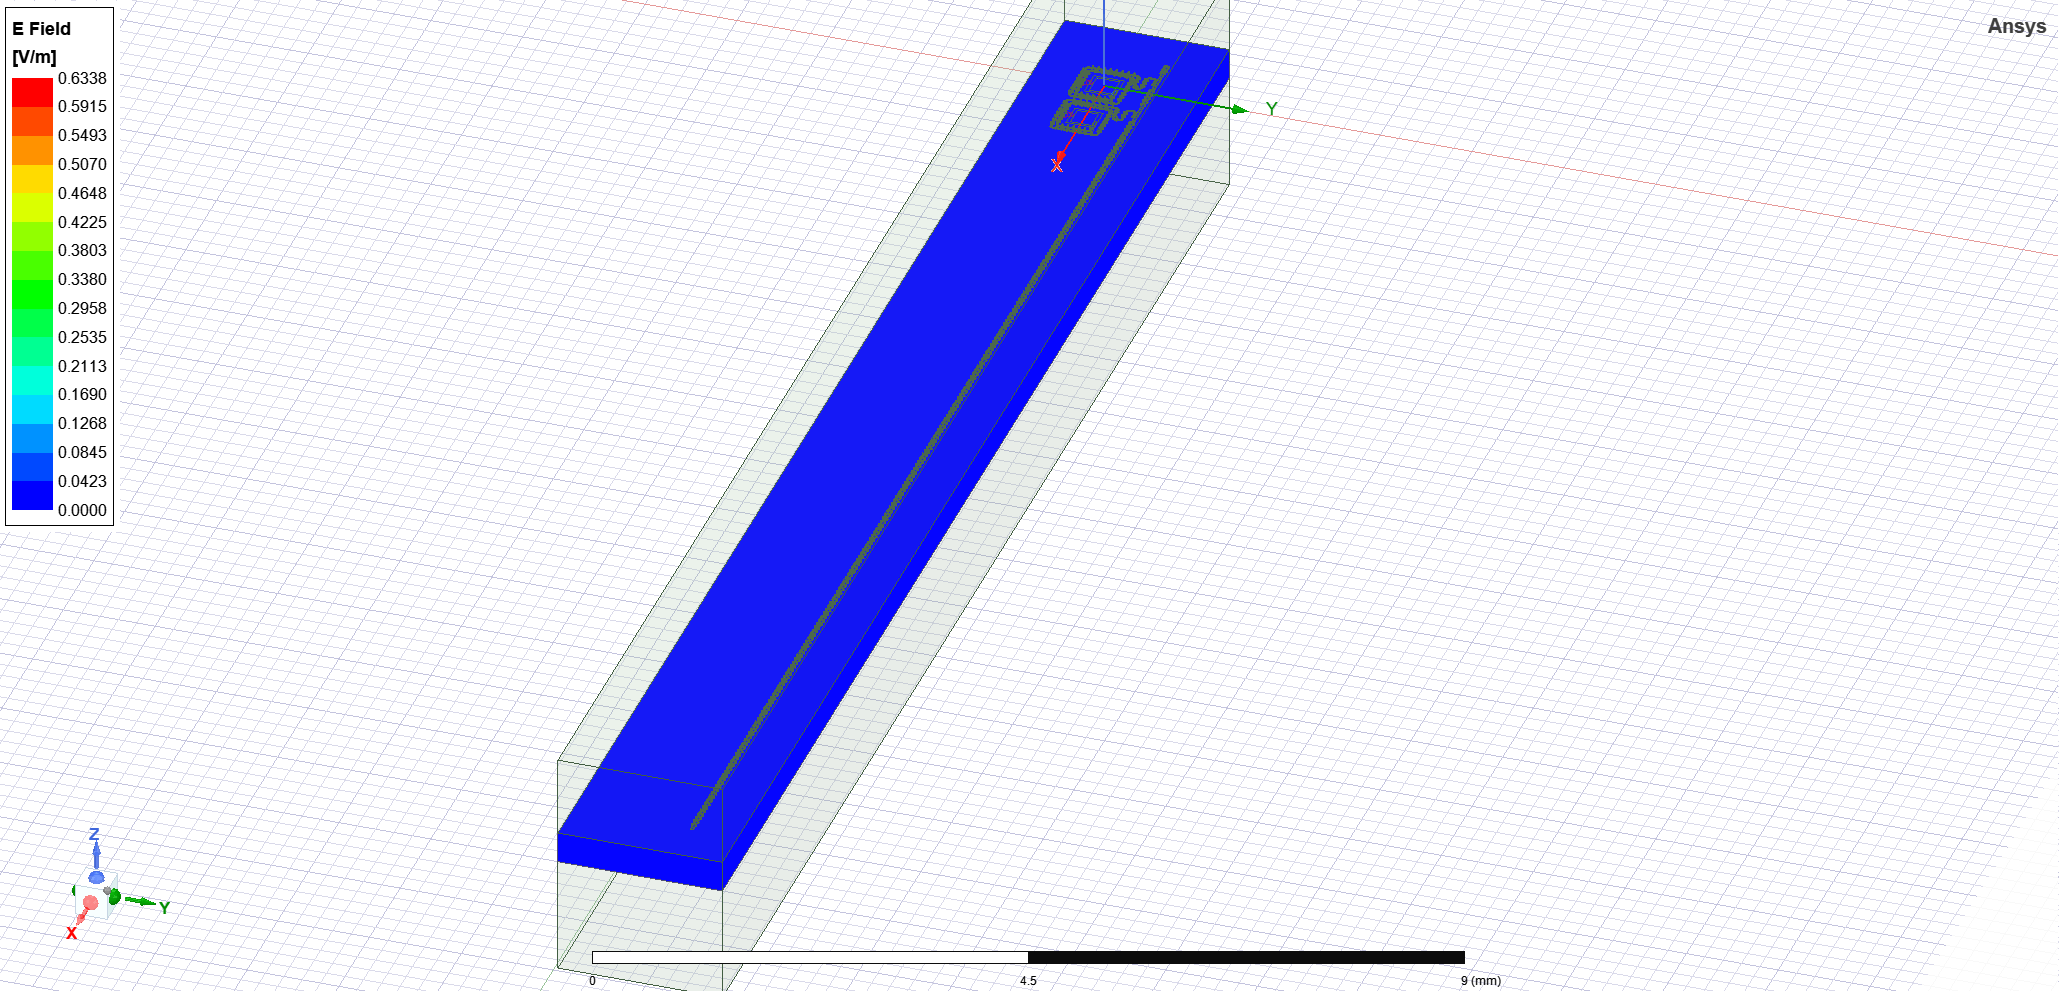

WindowsPath('c:/Users/slab/Desktop/Wendy-qiskit-code/ansys.png')

In [49]:
hfss.modeler._modeler.ShowWindow()
hfss.set_mode(2,'Setup')
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [45]:
hfss.clear_fields(['Mag_E1'])

In [53]:
source = 'C:\Users\slab\Desktop\Wendy-qiskit-code\ansys.png'
path = 'C:\Users\slab\Desktop\Wendy-qiskit-code\Ansys_screenshoots\Simulation_0304'

dest = shutil.move(source, path)

OSError: [Errno 22] Invalid argument: 'C:\\Users\\slab\\Desktop\\Wendy-qiskit-code\x07nsys.png'

In [36]:
cpw2.options['anchors'] = anchor
gui.rebuild()

In [178]:
eig_all.sim.renderer.epr_quantum_analysis.get_frequencies().to_numpy()[:,0]

array([3869.48716432, 4082.7766546 , 5616.73862079, 6380.49308485])

In [456]:
import qutip as q
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import scipy.linalg as lin

In [487]:
r = lin.eig(lin.inv(C)@(L))


In [488]:
np.sqrt(r[0])*1000

array([29.48697281+0.j, 33.54183529+0.j])

In [498]:
(1/np.sqrt(13*u.nH*100*u.fF).si).to(u.GHz)/2/np.pi

<Quantity 4.41416391 GHz>

In [496]:
from Transmon_property import transmon_freq

In [497]:
transmon_freq(110*u.fF, 13*u.nH)

(<Quantity 4.03264716 GHz>, <Quantity 176.09299386 MHz>)

# Simulations

## Capacitance Matrix Calculation

Note that when we calculate capacitance matrix, we need to ``approximate" that the end pins of the CPW is not grounded to get the capacitance coupling. Thus we need to modify the designs above to get the desired capacitance matrix. 

In [14]:
draw_CPW(short=False)

In [15]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [16]:
c1.sim.setup.min_passes  = 1
c1.sim.setup.max_passes = 5
print(c1.sim.setup)

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'freq_ghz': 5.0, 'save_fields': False, 'enabled': True, 'max_passes': 5, 'min_passes': 1, 'min_converged_passes': 2, 'percent_error': 0.5, 'percent_refinement': 30, 'auto_increase_solution_order': True, 'solution_order': 'High', 'solver_type': 'Iterative'}


In [17]:
c1.sim.run(components=['Q1','cpw_1','end'])#, open_terminations=[('end', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
c1.sim.capacitance_matrix 

c1.sim._get_results_from_renderer()
c_mat = c1.sim.capacitance_matrix

INFO 03:43PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:43PM [load_ansys_project]: 	Opened Ansys App
INFO 03:43PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 03:43PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/slab/Documents/Ansoft/
	Project:   Project14
INFO 03:43PM [connect_design]: 	Opened active design
	Design:    TwoTransmons_hfss [Solution type: Eigenmode]
INFO 03:43PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 03:43PM [connect]: 	Connected to project "Project14" and design "TwoTransmons_hfss" 😀 

INFO 03:43PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
WARNING 03:43PM [connect_setup]: 	No design setup detected.
WARNING 03:43PM [connect_setup]: 	Creating Q3D default setup.
INFO 03:43PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:43PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:4

In [18]:
c_mat

,a_connector_pad_Q1,g_wb,pad_top_Q1
a_connector_pad_Q1,664.98231,-642.09047,-18.99471
g_wb,-642.09047,784.66027,-77.15847
pad_top_Q1,-18.99471,-77.15847,98.09671


In the capacitance matrix above, the ground plane is named "g_wb" The big metal pad in the junction pocket is called "pad_top_Q1" The CPW is connected with the connector pad, thus its name is "a_connector_pad"

In [19]:
c1.clear_data()

## EPR Analysis

In [20]:
import numpy as np
from qiskit_metal.analyses.quantization import EPRanalysis

In [21]:
hfss.clean_active_design()

NameError: name 'hfss' is not defined

INFO 03:48PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:48PM [load_ansys_project]: 	Opened Ansys App
INFO 03:48PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 03:48PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/slab/Documents/Ansoft/
	Project:   Project14
INFO 03:48PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 03:48PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:48PM [connect]: 	Connected to project "Project14" and design "Design_q3d" 😀 

03:48PM 33s WARNING [activate_ansys_design]: The design_name=readout was not in active project.  Designs in active project are: 
['Qbit_hfss', 'Design_q3d', 'TwoTransmons_hfss', 'TransmonResonator_hfss', 'Readout_hfss'].  A new design will be added to the project.  
INFO 03:48PM [connect_design]: 	Opened active design
	Design:    readout [Solution type: Eigenmode]
WARNING 03:48PM [connect_setup]: 	No design setup det

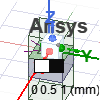

INFO 03:48PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 40
Convergence freq max delta percent diff  = 0.1



In [22]:

draw_CPW()
# design.delete_component('Q1')
eig_res = EPRanalysis(design, "hfss")

hfss = eig_res.sim.renderer
hfss.start()

hfss.activate_ansys_design('readout','eigenmode')

hfss.render_design(['cpw_1','Q1','end'],[])
hfss.save_screenshot()

setup = hfss.pinfo.setup
setup.passes = 40
setup.min_converged = 9
setup.n_modes = 2

print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

# Next 2 lines are counterinuitive, since there is no junction in this resonator.
# However, these are necessary to make pyEPR work correctly. Please do note delete
hfss.pinfo.design.set_variable('Lj', '10 nH')
hfss.pinfo.design.set_variable('Cj', '0 fF')

setup.analyze()

In [23]:
eig_res.get_frequencies()

Design "readout" info:
	# eigenmodes    2
	# variations    1
Design "readout" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        6.336721             inf
          1        7.000849             inf

In [24]:
eig_res.sim.convergence_t, eig_res.sim.convergence_f, _ = hfss.get_convergences()
eig_res.sim.plot_convergences()

03:56PM 47s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


03:56PM 51s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


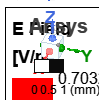

WindowsPath('c:/Users/slab/Desktop/Wendy-qiskit-code/ansys.png')

In [25]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [26]:
hfss.clear_fields(['Mag_E1'])

In [27]:
hfss.set_mode(2, "Setup")

INFO 03:57PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


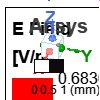

WindowsPath('c:/Users/slab/Desktop/Wendy-qiskit-code/ansys.png')

In [28]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_fields('main')
hfss.save_screenshot()

In [29]:
eig_res.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'min_freq_ghz': 1,
 'n_modes': 1,
 'max_delta_f': 0.5,
 'max_passes': 10,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'}}

In [30]:
eig_res.setup

{'junctions': {'jj': {'Lj_variable': 'Lj',
   'Cj_variable': 'Cj',
   'rect': '',
   'line': ''}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 7,
 'sweep_variable': 'Lj'}

In [31]:
eig_res.setup.junctions.jj.rect = 'JJ_rect_Lj_Q1_rect_jj'
eig_res.setup.junctions.jj.line = 'JJ_Lj_Q1_rect_jj_'
eig_res.setup

{'junctions': {'jj': {'Lj_variable': 'Lj',
   'Cj_variable': 'Cj',
   'rect': 'JJ_rect_Lj_Q1_rect_jj',
   'line': 'JJ_Lj_Q1_rect_jj_'}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 8,
 'fock_trunc': 7,
 'sweep_variable': 'Lj'}

In [33]:
eig_res.run_epr()

Design "readout" info:
	# eigenmodes    2
	# variations    1
Design "readout" info:
	# eigenmodes    2
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.30257249753934e-24
        energy_elec_substrate = 1.19677535080225e-24
        EPR of substrate = 91.9%

        energy_mag    = 9.23737451177308e-25
        energy_mag % of energy_elec_all  = 70.9%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 6.34 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               69.6%  7.452e-26 2.265e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 96.93%
	jj              0.391572  (+)        0.0124145
		(U_tot_cap-U_tot_ind)/mean=18.56%
Calculating Qdielectric_main for mode 0 (0/1)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9208738470290613


  _Om = pd.Series({})




  Mode 1 at 7.00 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               29.1%  6.513e-25 4.619e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 96.27%
	jj              0.163614  (+)        0.00633158
		(U_tot_cap-U_tot_ind)/mean=7.11%
Calculating Qdielectric_main for mode 1 (1/1)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_1 = 0.9187783045189813


  options=pd.Series(get_instance_vars(self.options)),

WARNING 04:01PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 04:01PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 37.1% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 04:01PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 37.1% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project14\readout\2023-02-01 16-01-42.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.665299
1    1.508216
dtype: float64

Pm_norm idx =
     jj
0  True
1  True
*** P (participation matrix, not normlz.)
         jj
0  0.386770
1  0.162585

*** S (sign-bit matrix)
   s_jj
0    -1
1     1
*** P (participation matrix, normalized.)
      0.64
      0.25

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       127      107
       107     22.5

*** Chi matrix ND (MHz) 
       211     62.8
      62.8      6.5

*** Frequencies O1 PT (MHz)
0    6155.757442
1    6924.733448
dtype: float64

*** Frequencies ND (MHz)
0    6130.144212
1    6940.601897
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj,10
0,6130.14
1,6940.60


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0      1
Lj                 
10 0  211.11  62.83
   1   62.83   6.50

In [5]:
from tqdm import tqdm
import numpy as np
import time

In [8]:
for member in tqdm(np.linspace(0,100,100)):
    time.sleep(0.1)
    print(member)

  2%|▏         | 2/100 [00:00<00:10,  9.31it/s]

0.0
1.0101010101010102


  4%|▍         | 4/100 [00:00<00:10,  9.16it/s]

2.0202020202020203
3.0303030303030303


  6%|▌         | 6/100 [00:00<00:10,  9.10it/s]

4.040404040404041
5.050505050505051


  8%|▊         | 8/100 [00:00<00:10,  9.08it/s]

6.0606060606060606
7.070707070707071


 10%|█         | 10/100 [00:01<00:09,  9.08it/s]

8.080808080808081
9.090909090909092


 12%|█▏        | 12/100 [00:01<00:09,  9.05it/s]

10.101010101010102
11.111111111111112


 14%|█▍        | 14/100 [00:01<00:09,  9.05it/s]

12.121212121212121
13.131313131313131


 16%|█▌        | 16/100 [00:01<00:09,  9.03it/s]

14.141414141414142
15.151515151515152


 18%|█▊        | 18/100 [00:01<00:09,  8.98it/s]

16.161616161616163
17.171717171717173


 20%|██        | 20/100 [00:02<00:08,  9.00it/s]

18.181818181818183
19.191919191919194


 22%|██▏       | 22/100 [00:02<00:08,  9.03it/s]

20.202020202020204
21.212121212121215


 24%|██▍       | 24/100 [00:02<00:08,  9.03it/s]

22.222222222222225
23.232323232323235


 26%|██▌       | 26/100 [00:02<00:08,  9.05it/s]

24.242424242424242
25.252525252525253


 28%|██▊       | 28/100 [00:03<00:07,  9.01it/s]

26.262626262626263
27.272727272727273


 30%|███       | 30/100 [00:03<00:07,  9.06it/s]

28.282828282828284
29.292929292929294


 32%|███▏      | 32/100 [00:03<00:07,  9.01it/s]

30.303030303030305
31.313131313131315


 34%|███▍      | 34/100 [00:03<00:07,  9.02it/s]

32.323232323232325
33.333333333333336


 36%|███▌      | 36/100 [00:03<00:07,  9.08it/s]

34.343434343434346
35.35353535353536


 38%|███▊      | 38/100 [00:04<00:06,  9.07it/s]

36.36363636363637
37.37373737373738


 40%|████      | 40/100 [00:04<00:06,  9.04it/s]

38.38383838383839
39.3939393939394


 42%|████▏     | 42/100 [00:04<00:06,  9.04it/s]

40.40404040404041
41.41414141414142


 44%|████▍     | 44/100 [00:04<00:06,  9.06it/s]

42.42424242424243
43.43434343434344


 46%|████▌     | 46/100 [00:05<00:05,  9.09it/s]

44.44444444444445
45.45454545454546


 48%|████▊     | 48/100 [00:05<00:05,  9.11it/s]

46.46464646464647
47.47474747474748


 50%|█████     | 50/100 [00:05<00:05,  9.03it/s]

48.484848484848484
49.494949494949495


 52%|█████▏    | 52/100 [00:05<00:05,  9.04it/s]

50.505050505050505
51.515151515151516


 54%|█████▍    | 54/100 [00:05<00:05,  9.06it/s]

52.525252525252526
53.535353535353536


 56%|█████▌    | 56/100 [00:06<00:04,  8.99it/s]

54.54545454545455
55.55555555555556


 58%|█████▊    | 58/100 [00:06<00:04,  8.99it/s]

56.56565656565657
57.57575757575758


 60%|██████    | 60/100 [00:06<00:04,  8.98it/s]

58.58585858585859
59.5959595959596


 62%|██████▏   | 62/100 [00:06<00:04,  9.00it/s]

60.60606060606061
61.61616161616162


 64%|██████▍   | 64/100 [00:07<00:03,  9.05it/s]

62.62626262626263
63.63636363636364


 66%|██████▌   | 66/100 [00:07<00:03,  9.10it/s]

64.64646464646465
65.65656565656566


 68%|██████▊   | 68/100 [00:07<00:03,  9.09it/s]

66.66666666666667
67.67676767676768


 70%|███████   | 70/100 [00:07<00:03,  9.05it/s]

68.68686868686869
69.6969696969697


 72%|███████▏  | 72/100 [00:07<00:03,  9.00it/s]

70.70707070707071
71.71717171717172


 74%|███████▍  | 74/100 [00:08<00:02,  9.04it/s]

72.72727272727273
73.73737373737374


 76%|███████▌  | 76/100 [00:08<00:02,  9.04it/s]

74.74747474747475
75.75757575757576


 78%|███████▊  | 78/100 [00:08<00:02,  9.02it/s]

76.76767676767678
77.77777777777779


 80%|████████  | 80/100 [00:08<00:02,  9.05it/s]

78.7878787878788
79.7979797979798


 82%|████████▏ | 82/100 [00:09<00:01,  9.07it/s]

80.80808080808082
81.81818181818183


 84%|████████▍ | 84/100 [00:09<00:01,  9.05it/s]

82.82828282828284
83.83838383838385


 86%|████████▌ | 86/100 [00:09<00:01,  9.04it/s]

84.84848484848486
85.85858585858587


 88%|████████▊ | 88/100 [00:09<00:01,  9.01it/s]

86.86868686868688
87.87878787878789


 90%|█████████ | 90/100 [00:09<00:01,  8.99it/s]

88.8888888888889
89.89898989898991


 92%|█████████▏| 92/100 [00:10<00:00,  9.17it/s]

90.90909090909092
91.91919191919193


 94%|█████████▍| 94/100 [00:10<00:00,  9.18it/s]

92.92929292929294
93.93939393939395


 96%|█████████▌| 96/100 [00:10<00:00,  9.15it/s]

94.94949494949496
95.95959595959597


 98%|█████████▊| 98/100 [00:10<00:00,  9.08it/s]

96.96969696969697
97.97979797979798


100%|██████████| 100/100 [00:11<00:00,  9.06it/s]

98.98989898989899
100.0


## Save Design to GDS

In [18]:
a_gds = design.renderers.gds

In [19]:
a_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'fabricate': 'False',
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

In [20]:
a_gds.options['path_filename'] = 'Customized_Components\Fake_Junctions.GDS'

In [21]:

a_gds.options['short_segments_to_not_fillet'] = 'False'
a_gds.export_to_gds('One pad design.gds')

1

The rest of the notebook is just a scratch paper :D

In [130]:
q3d.clean_active_design()

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5,
 'max_delta_s': 0.1,
 'max_passes': 10,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'},
 'sweep_setup': {'name': 'Sweep',
  'start_ghz': 2.0,
  'stop_ghz': 8.0,
  'count': 101,
  'step_ghz': None,
  'type': 'Fast',
  'save_fields': False}}

In [51]:
import numpy as np
import scipy.linalg as la
import qutip as q
import astropy.units as u
import astropy.constants as con

class Single_Transmon_Circuit:
    ## Default constant
    eq = 1.602e-19*u.C 
    epsilon = con.eps0
    h = 6.636/10**34
    hbar = con.hbar
    kb = con.k_B
    Tc = 1.2
    delta = 1.764*kb*Tc
    phi0 = con.h/2/eq
    dielectric = 9.34*epsilon
    def __init__(self,cap_mat,pad_name,CPW_name,ground_plane_name = 'ground_main_plane') -> None:
        self.c_couple = -cap_mat[pad_name][CPW_name]*u.fF
        self.c_to_ground = cap_mat[pad_name][pad_name]
        self.c_CPW = cap_mat[CPW_name][CPW_name]

In [54]:
Single_Transmon_Circuit(c_mat,'pad_top_Q1','n_spiral_spiral')